# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 1 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.9891 # 1-(60/5*24)/50977

MODE_TRAIN_AE = False # False
MODE_AUTO_SELECT = 2  #0 # 0: False, 1: True, 2: from disk

MODE_TRAIN_PREDICTOR = True
MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

12

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_73683/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
61625  1691018700000   1838.84   1840.65  1838.83    1840.64    565.5509   
61626  1691019000000   1840.65   1840.65  1839.49    1839.49    186.1157   
61627  1691019300000   1839.50   1839.50  1837.83    1838.39    451.4727   
61628  1691019600000   1838.40   1838.59  1837.60    1838.58    307.7195   
61629  1691019900000   1838.59   1838.59  1838.58    1838.59      6.8825   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1748.127508        1747.54819   
1      2023-01-01 00:05:00       1748.127508        1747.54819   
2      2023-01-01 00:10:00       1748.127508        1747.54819   
3      2023-01-01 00:15:00       1748.127508        1747.54819   
4      2023-01-01 00:20:00       1748.127508        1747.54819   
...                    ...               ...               ...   
61625  2023-08-02 23:25:00       1840.925000        1835.14000   
61626  2023-08-02 23:30:00       1841.152500        1837.12000   
61627  2023-08-02 23:35:00       1841.527500        1837.22000   
61628  2023-08-02 23:40:00       1841.527500        1837.22000   
61629  2023-08-02 23:45:00       1841.567500        1837.22000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
61625        1842.120  ...   NaN         NaN            NaN           NaN   
61626        1842.120  ...   NaN         NaN            NaN           NaN   
61627        1841.705  ...   NaN         NaN            NaN           NaN   
61628        1841.590  ...   NaN         NaN            NaN           NaN   
61629        1841.590  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
61625               NaN         0.0               NaN         0.0      0.0   
61626               NaN         0.0               NaN         0.0      0.0   
61627               NaN         0.0               NaN         0.0      0.0   
61628               NaN         0.0               NaN         0.0      0.0   
61629               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
61625   NaN  
61626   NaN  
61627   NaN  
61628   NaN  
61629   NaN  

[61630 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
61625  1691018700000   1838.84   1840.65  1838.83    1840.64    565.5509   
61626  1691019000000   1840.65   1840.65  1839.49    1839.49    186.1157   
61627  1691019300000   1839.50   1839.50  1837.83    1838.39    451.4727   
61628  1691019600000   1838.40   1838.59  1837.60    1838.58    307.7195   
61629  1691019900000   1838.59   1838.59  1838.58    1838.59      6.8825   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1748.127508        1747.54819   
1      2023-01-01 00:05:00       1748.127508        1747.54819   
2      2023-01-01 00:10:00       1748.127508        1747.54819   
3      2023-01-01 00:15:00       1748.127508        1747.54819   
4      2023-01-01 00:20:00       1748.127508        1747.54819   
...                    ...               ...               ...   
61625  2023-08-02 23:25:00       1840.925000        1835.14000   
61626  2023-08-02 23:30:00       1841.152500        1837.12000   
61627  2023-08-02 23:35:00       1841.527500        1837.22000   
61628  2023-08-02 23:40:00       1841.527500        1837.22000   
61629  2023-08-02 23:45:00       1841.567500        1837.22000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
61625        1842.120  ...   NaN         NaN            NaN           NaN   
61626        1842.120  ...   NaN         NaN            NaN           NaN   
61627        1841.705  ...   NaN         NaN            NaN           NaN   
61628        1841.590  ...   NaN         NaN            NaN           NaN   
61629        1841.590  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
61625               NaN         0.0               NaN         0.0      0.0   
61626               NaN         0.0               NaN         0.0      0.0   
61627               NaN         0.0               NaN         0.0      0.0   
61628               NaN         0.0               NaN         0.0      0.0   
61629               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
61625                  NaN  
61626                  NaN  
61627                  NaN  
61628                  NaN  
61629                  NaN  

[61630 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       5889
delta_event_real    5889
delta_event_pred    5889
Previous_num        5889
Actual_num          5889
Event               5889
Date                5889
Previous            5889
Consensus           5889
Actual              5889
Country             5889
Time (ET)           5889
keep                5889
date                5889
dtype: int64

on 61630 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
61625   1838.84   1840.65  1838.83    1840.64    565.5509   
61626   1840.65   1840.65  1839.49    1839.49    186.1157   
61627   1839.50   1839.50  1837.83    1838.39    451.4727   
61628   1838.40   1838.59  1837.60    1838.58    307.7195   
61629   1838.59   1838.59  1838.58    1838.59      6.8825   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1748.127508        1747.54819   
1      2023-01-01 00:05:00       1748.127508        1747.54819   
2      2023-01-01 00:10:00       1748.127508        1747.54819   
3      2023-01-01 00:15:00       1748.127508        1747.54819   
4      2023-01-01 00:20:00       1748.127508        1747.54819   
...                    ...               ...               ...   
61625  2023-08-02 23:25:00       1840.925000        1835.14000   
61626  2023-08-02 23:30:00       1841.152500        1837.12000   
61627  2023-08-02 23:35:00       1841.527500        1837.22000   
61628  2023-08-02 23:40:00       1841.527500        1837.22000   
61629  2023-08-02 23:45:00       1841.567500        1837.22000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
61625        1842.120         1841.415  ...  1875.460163  1858.366821   
61626        1842.120         1841.010  ...  1875.456527  1858.369555   
61627        1841.705         1840.450  ...  1875.446527  1858.371033   
61628        1841.590         1840.105  ...  1875.432782  1858.373062   
61629        1841.590         1839.645  ...  1875.425081  1858.375588   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
61625  1857.483549  1896.152848   1731.300473          0.605444  0.059403   
61626  1857.476446  1896.132704   1731.300693          0.599078  0.058815   
61627  1857.468138  1896.116050   1731.301221          0.592988  0.058251   
61628  1857.462308  1896.106833   1731.301580          0.594042  0.058349   
61629  1857.455271  1896.089702   1731.301588          0.594100  0.058354   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.897668  
1      1.205254e+08      522461.0       17.897668  
2      1.205254e+08      522461.0       17.897668  
3      1.205254e+08      522461.0       17.897668  
4      1.205254e+08      522461.0       17.897668  
...             ...           ...             ...  
61625  1.211626e+08      430765.0       18.555683  
61626  1.211626e+08      430765.0       18.555683  
61627  1.211626e+08      430765.0       18.555683  
61628  1.211626e+08      430765.0       18.555683  
61629  1.211626e+08      430765.0       18.555683  

[61630 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [21]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [22]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [23]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [24]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [25]:
df_feat.shape[0]

61630

In [26]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

60958

In [27]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
61625  1691018700000   1838.84   1840.65  1838.83    1840.64    565.5509   
61626  1691019000000   1840.65   1840.65  1839.49    1839.49    186.1157   
61627  1691019300000   1839.50   1839.50  1837.83    1838.39    451.4727   
61628  1691019600000   1838.40   1838.59  1837.60    1838.58    307.7195   
61629  1691019900000   1838.59   1838.59  1838.58    1838.59      6.8825   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1748.127508        1747.54819   
1      2023-01-01 00:05:00       1748.127508        1747.54819   
2      2023-01-01 00:10:00       1748.127508        1747.54819   
3      2023-01-01 00:15:00       1748.127508        1747.54819   
4      2023-01-01 00:20:00       1748.127508        1747.54819   
...                    ...               ...               ...   
61625  2023-08-02 23:25:00       1840.925000        1835.14000   
61626  2023-08-02 23:30:00       1841.152500        1837.12000   
61627  2023-08-02 23:35:00       1841.527500        1837.22000   
61628  2023-08-02 23:40:00       1841.527500        1837.22000   
61629  2023-08-02 23:45:00       1841.567500        1837.22000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
61625        1842.120  ...         NaN            NaN           NaN   
61626        1842.120  ...         NaN            NaN           NaN   
61627        1841.705  ...         NaN            NaN           NaN   
61628        1841.590  ...         NaN            NaN           NaN   
61629        1841.590  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
61625               NaN         0.0               NaN         0.0      0.0   
61626               NaN         0.0               NaN         0.0      0.0   
61627               NaN         0.0               NaN         0.0      0.0   
61628               NaN         0.0               NaN         0.0      0.0   
61629               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
61625                  NaN  False  
61626                  NaN  False  
61627                  NaN  False  
61628                  NaN  False  
61629                  NaN  False  

[61630 rows x 136 columns]

In [28]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
60954  1690817400000   1859.33   1859.49  1857.80    1859.29   1500.4467   
60955  1690817700000   1859.29   1860.00  1858.84    1859.80    636.1948   
60956  1690818000000   1859.81   1859.81  1856.92    1857.63   1321.1470   
60957  1690818300000   1857.63   1859.32  1856.67    1858.85    558.0419   
60958  1690818600000   1858.85   1859.58  1857.41    1858.50    745.5537   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1748.127508        1747.54819   
1      2023-01-01 00:05:00       1748.127508        1747.54819   
2      2023-01-01 00:10:00       1748.127508        1747.54819   
3      2023-01-01 00:15:00       1748.127508        1747.54819   
4      2023-01-01 00:20:00       1748.127508        1747.54819   
...                    ...               ...               ...   
60954  2023-07-31 15:30:00       1871.085000        1869.41000   
60955  2023-07-31 15:35:00       1870.910000        1869.41000   
60956  2023-07-31 15:40:00       1870.532500        1869.41000   
60957  2023-07-31 15:45:00       1870.230000        1869.41000   
60958  2023-07-31 15:50:00       1869.842500        1869.41000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
60954        1864.580  ...         NaN            NaN           NaN   
60955        1864.580  ...         NaN            NaN           NaN   
60956        1862.995  ...         NaN            NaN           NaN   
60957        1862.870  ...         NaN            NaN           NaN   
60958        1862.870  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
60954               NaN         0.0               NaN         0.0      0.0   
60955               NaN         0.0               NaN         0.0      0.0   
60956               NaN         0.0               NaN         0.0      0.0   
60957               NaN         0.0               NaN         0.0      0.0   
60958               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
60954                  NaN   True  
60955                  NaN   True  
60956                  NaN   True  
60957                  NaN   True  
60958                  NaN   True  

[60959 rows x 136 columns]

In [29]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
60959  1690818900000   1858.49   1859.40  1857.06    1857.37    465.1047   
60960  1690819200000   1857.37   1857.88  1855.43    1857.88   3128.6127   
60961  1690819500000   1857.88   1857.88  1854.41    1856.01   1371.8221   
60962  1690819800000   1856.01   1857.44  1854.81    1857.43   1179.2888   
60963  1690820100000   1857.43   1859.74  1856.06    1859.45   1508.5391   
...              ...       ...       ...      ...        ...         ...   
61625  1691018700000   1838.84   1840.65  1838.83    1840.64    565.5509   
61626  1691019000000   1840.65   1840.65  1839.49    1839.49    186.1157   
61627  1691019300000   1839.50   1839.50  1837.83    1838.39    451.4727   
61628  1691019600000   1838.40   1838.59  1837.60    1838.58    307.7195   
61629  1691019900000   1838.59   1838.59  1838.58    1838.59      6.8825   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
60959  2023-07-31 15:55:00         1869.8425          1869.410   
60960  2023-07-31 16:00:00         1867.7275          1868.015   
60961  2023-07-31 16:05:00         1867.7275          1868.015   
60962  2023-07-31 16:10:00         1866.5875          1866.875   
60963  2023-07-31 16:15:00         1866.4125          1866.875   
...                    ...               ...               ...   
61625  2023-08-02 23:25:00         1840.9250          1835.140   
61626  2023-08-02 23:30:00         1841.1525          1837.120   
61627  2023-08-02 23:35:00         1841.5275          1837.220   
61628  2023-08-02 23:40:00         1841.5275          1837.220   
61629  2023-08-02 23:45:00         1841.5675          1837.220   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
60959        1862.870  ...         NaN            NaN           NaN   
60960        1860.445  ...         NaN            NaN           NaN   
60961        1859.935  ...         NaN            NaN           NaN   
60962        1859.935  ...         NaN            NaN           NaN   
60963        1859.935  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
61625        1842.120  ...         NaN            NaN           NaN   
61626        1842.120  ...         NaN            NaN           NaN   
61627        1841.705  ...         NaN            NaN           NaN   
61628        1841.590  ...         NaN            NaN           NaN   
61629        1841.590  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
60959               NaN         0.0               NaN         0.0      0.0   
60960               NaN         0.0               NaN         0.0      0.0   
60961               NaN         0.0               NaN         0.0      0.0   
60962               NaN         0.0               NaN         0.0      0.0   
60963               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
61625               NaN         0.0               NaN         0.0      0.0   
61626               NaN         0.0               NaN         0.0      0.0   
61627               NaN         0.0               NaN         0.0      0.0   
61628               NaN         0.0               NaN         0.0      0.0   
61629               NaN         0.0               NaN         0.0      0.0   

       date  train  
60959   NaN  False  
60960   NaN  False  
60961   NaN  False  
60962   NaN  False  
60963   NaN  False  
...     ...    ...  
61625   NaN  False  
61626   NaN  False  
61627   NaN  False  
61628   NaN  False  
61629   NaN  False  

[671 rows x 136 columns]

In [30]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [31]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [32]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [33]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60932, 12, 104) (60932, 15)
(644, 12, 104) (644, 15)


In [34]:
X_train

array([[[1.00186753, 1.00170841, 1.00186753, ..., 0.        ,
         0.        , 0.        ],
        [1.00108032, 1.00185916, 1.00217739, ..., 0.        ,
         0.        , 0.        ],
        [1.00038523, 1.00108032, 1.00144043, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.0004606 , 0.99962314, 1.00081233, ..., 0.        ,
         0.        , 0.        ],
        [1.00061134, 1.00046898, 1.00081233, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.00061134, 1.00079558, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00107194, 1.00185077, 1.002169  , ..., 0.        ,
         0.        , 0.        ],
        [1.00037685, 1.00107194, 1.00143204, ..., 0.        ,
         0.        , 0.        ],
        [1.00157441, 1.00037685, 1.00157441, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.00060296, 1.0004606 , 1.00080395, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [35]:
seq_y

array([1.00082757, 1.00167663, 1.001107  , 1.00070934, 1.00025257,
       1.00063948, 0.99985491, 1.00008598, 0.99959159, 0.99932827,
       0.99917243, 0.99914557, 0.99941963, 0.99825351, 0.99890912])

In [36]:
y_train

array([[1.00000837, 1.00133993, 1.00108032, ..., 1.00010049, 1.00023449,
        1.00094633],
       [1.00133155, 1.00107194, 1.00107194, ..., 1.00022611, 1.00093794,
        1.00103006],
       [0.99974074, 0.99974074, 0.99992473, ..., 0.99960692, 0.99969892,
        0.99974074],
       ...,
       [1.00017184, 0.99928579, 1.00011277, ..., 0.99845882, 0.99843197,
        0.99870584],
       [0.99911411, 0.99994094, 1.00078925, ..., 0.99826043, 0.99853425,
        0.99736917],
       [1.00082757, 1.00167663, 1.001107  , ..., 0.99941963, 0.99825351,
        0.99890912]])

In [37]:
seq_y

array([1.00082757, 1.00167663, 1.001107  , 1.00070934, 1.00025257,
       1.00063948, 0.99985491, 1.00008598, 0.99959159, 0.99932827,
       0.99917243, 0.99914557, 0.99941963, 0.99825351, 0.99890912])

In [38]:
y_train

array([[1.00000837, 1.00133993, 1.00108032, ..., 1.00010049, 1.00023449,
        1.00094633],
       [1.00133155, 1.00107194, 1.00107194, ..., 1.00022611, 1.00093794,
        1.00103006],
       [0.99974074, 0.99974074, 0.99992473, ..., 0.99960692, 0.99969892,
        0.99974074],
       ...,
       [1.00017184, 0.99928579, 1.00011277, ..., 0.99845882, 0.99843197,
        0.99870584],
       [0.99911411, 0.99994094, 1.00078925, ..., 0.99826043, 0.99853425,
        0.99736917],
       [1.00082757, 1.00167663, 1.001107  , ..., 0.99941963, 0.99825351,
        0.99890912]])

In [39]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [40]:
X_train.shape

(60932, 12, 104)

In [41]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(60932, 12, 104) (60932, 15)
(644, 12, 104) (644, 15)


## Standardization

In [42]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [43]:
y_train

array([[1.00000837, 1.00133993, 1.00108032, ..., 1.00010049, 1.00023449,
        1.00094633],
       [1.00133155, 1.00107194, 1.00107194, ..., 1.00022611, 1.00093794,
        1.00103006],
       [0.99974074, 0.99974074, 0.99992473, ..., 0.99960692, 0.99969892,
        0.99974074],
       ...,
       [1.00017184, 0.99928579, 1.00011277, ..., 0.99845882, 0.99843197,
        0.99870584],
       [0.99911411, 0.99994094, 1.00078925, ..., 0.99826043, 0.99853425,
        0.99736917],
       [1.00082757, 1.00167663, 1.001107  , ..., 0.99941963, 0.99825351,
        0.99890912]])

In [44]:
np.mean(y_train_sca)

-2.083462891095731e-05

In [45]:
np.std(y_train_sca)

0.9999551394424256

In [46]:
np.mean(y_test_sca)

-0.042402292117916

In [47]:
np.std(y_test_sca)

0.6558223493670372

### Check unscaling

In [48]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1748.127508        1747.54819   
1    1195.38   1196.31   1196.69  1194.90       1748.127508        1747.54819   
2    1194.55   1195.38   1195.81  1194.55       1748.127508        1747.54819   
3    1195.98   1194.55   1195.98  1194.31       1748.127508        1747.54819   
4    1196.06   1195.98   1196.37  1195.97       1748.127508        1747.54819   
5    1196.61   1196.06   1196.70  1196.06       1748.127508        1747.54819   
6    1194.36   1196.62   1196.62  1193.72       1748.127508        1747.54819   
7    1194.22   1194.37   1194.43  1192.72       1748.127508        1747.54819   
8    1193.64   1194.22   1194.22  1193.02       1748.127508        1747.54819   
9    1194.64   1193.64   1195.06  1193.63       1748.127508        1747.54819   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1751.384742   
1         1194.71          1194.71           1751.384742   
2         1194.71          1194.71           1751.384742   
3         1194.71          1194.71           1751.384742   
4         1194.71          1194.71           1751.384742   
5         1194.71          1194.71           1751.384742   
6         1194.71          1194.71           1751.384742   
7         1194.71          1194.71           1751.384742   
8         1194.71          1194.71           1751.384742   
9         1194.71          1194.71           1751.384742   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0           1741.641782  ...       0.0      0.62349    -0.781831   
1           1741.641782  ...       0.0      0.62349    -0.781831   
2           1741.641782  ...       0.0      0.62349    -0.781831   
3           1741.641782  ...       0.0      0.62349    -0.781831   
4           1741.641782  ...       0.0      0.62349    -0.781831   
5           1741.641782  ...       0.0      0.62349    -0.781831   
6           1741.641782  ...       0.0      0.62349    -0.781831   
7           1741.641782  ...       0.0      0.62349    -0.781831   
8           1741.641782  ...       0.0      0.62349    -0.781831   
9           1741.641782  ...       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0           0.97953          0.201299   0.866025        0.5      0.0   
1           0.97953          0.201299   0.866025        0.5      0.0   
2           0.97953          0.201299   0.866025        0.5      0.0   
3           0.97953          0.201299   0.866025        0.5      0.0   
4           0.97953          0.201299   0.866025        0.5      0.0   
5           0.97953          0.201299   0.866025        0.5      0.0   
6           0.97953          0.201299   0.866025        0.5      0.0   
7           0.97953          0.201299   0.866025        0.5      0.0   
8           0.97953          0.201299   0.866025        0.5      0.0   
9           0.97953          0.201299   0.866025        0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [49]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [50]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [51]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [52]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [53]:
X_train.reshape(-1, X_train.shape[-1]).shape

(731184, 104)

In [54]:
X_train[:,-1,:].shape

(60932, 104)

In [55]:
X_test[:,-1,:].shape

(644, 104)

In [56]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.009781  0.171668 -0.001787  0.244192         37.987719   
1       0.009781  0.008426 -0.049818  0.185249         37.986716   
2       0.009781 -0.337446 -0.205360 -0.115790         37.827401   
3       0.009781  0.081147 -0.134532  0.244192         37.858429   
4       0.009781  0.010632 -0.193933  0.210223         37.858429   
...          ...       ...       ...       ...               ...   
61571   0.009781 -0.267792 -0.199820 -0.041943         -0.270317   
61572   0.009781 -0.049323 -0.174664  0.182577         -0.276240   
61573   0.009781  0.133454 -0.091724  0.242724         -0.238219   
61574   0.009781 -0.047910 -0.193898  0.182562         -0.252801   
61575   0.009781 -0.013639 -0.217584  0.219249         -0.258322   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0             35.792062        0.158670         0.162125   
1             35.791116        0.156974         0.160064   
2             35.640968       -0.112432        -0.167143   
3             35.670211       -0.059962        -0.111646   
4             35.670211       -0.059962        -0.201142   
...                 ...             ...              ...   
61571         -0.407374       -0.283977        -0.118209   
61572         -0.424419       -0.297070        -0.118175   
61573         -0.388657       -0.202818        -0.003573   
61574         -0.405711       -0.247763        -0.058222   
61575         -0.412364       -0.265297        -0.079542   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
0                  7.790050              7.305296  ...      0.87317   
1                  7.789845              7.305102  ...      0.87317   
2                  7.757327              7.274412  ...      0.87317   
3                  7.763660              7.280389  ...      0.87317   
4                  7.763660              7.280389  ...      0.87317   
...                     ...                   ...  ...          ...   
61571              0.205534              0.242364  ...     -0.32232   
61572              0.201786              0.238805  ...     -0.32232   
61573              0.209650              0.246271  ...     -0.32232   
61574              0.205900              0.242711  ...     -0.32232   
61575              0.204437              0.241322  ...     -0.32232   

       weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
0        -1.101474          1.389764          0.284403   1.669210   0.083297   
1        -1.101474          1.389764          0.284403   1.669210   0.083297   
2        -1.101474          1.389764          0.284403   1.669210   0.083297   
3        -1.101474          1.389764          0.284403   1.669210   0.083297   
4        -1.101474          1.389764          0.284403   1.669210   0.083297   
...            ...               ...               ...        ...        ...   
61571     1.385046          1.304011          0.557137  -0.334856  -2.640223   
61572     1.385046          1.304011          0.557137  -0.334856  -2.640223   
61573     1.385046          1.304011          0.557137  -0.334856  -2.640223   
61574     1.385046          1.304011          0.557137  -0.334856  -2.640223   
61575     1.385046          1.304011          0.557137  -0.334856  -2.640223   

        day_off  event_pred  event_real  TRAIN  
0     -0.057389   -0.001046   -0.002339    1.0  
1     -0.057389   -0.001046   -0.002339    1.0  
2     -0.057389   -0.001046   -0.002339    1.0  
3     -0.057389   -0.001046   -0.002339    1.0  
4     -0.057389   -0.001046   -0.002339    1.0  
...         ...         ...         ...    ...  
61571 -0.057389   -0.001046   -0.002339    0.0  
61572 -0.057389   -0.001046   -0.002339    0.0  
61573 -0.057389   -0.001046   -0.002339    0.0  
61574 -0.057389   -0.001046   -0.002339    0.0  
61575 -0.057389   -0.001046   -0.002339    0.0  

[61576 rows x 105 columns]

<AxesSubplot: xlabel='value', ylabel='variable'>

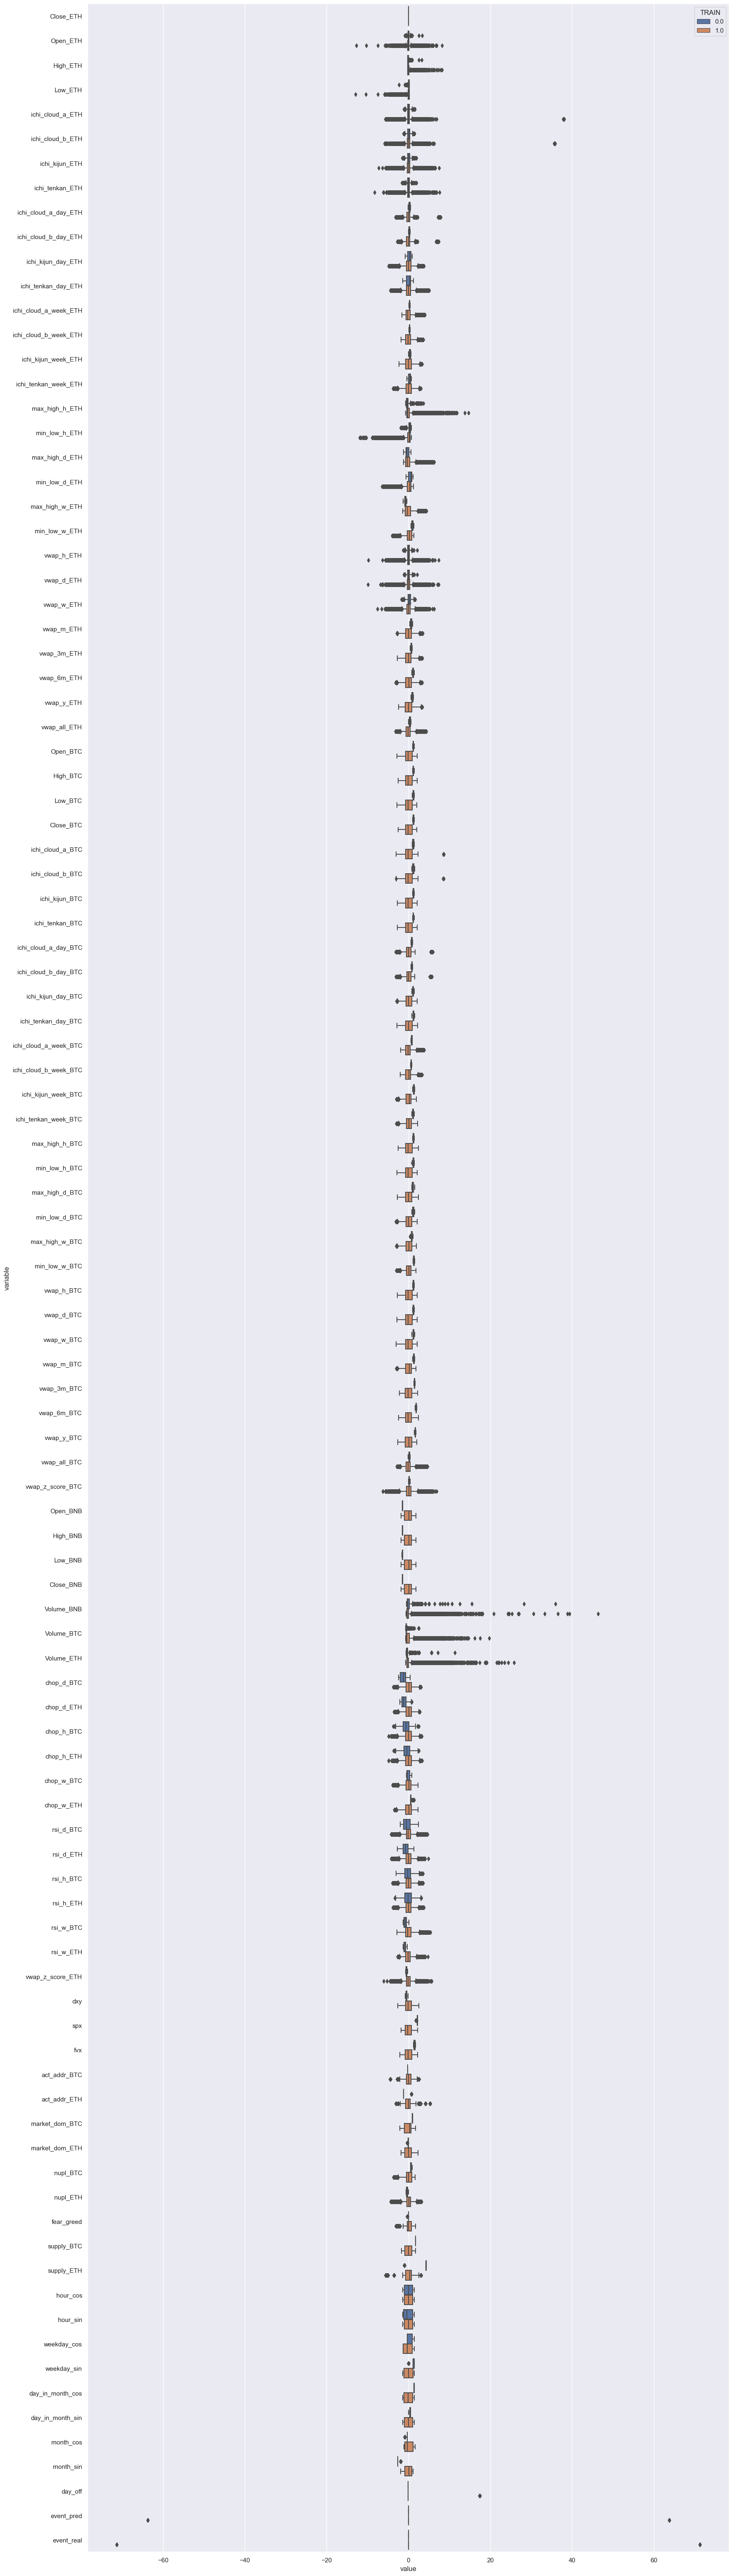

In [57]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")

<AxesSubplot: >

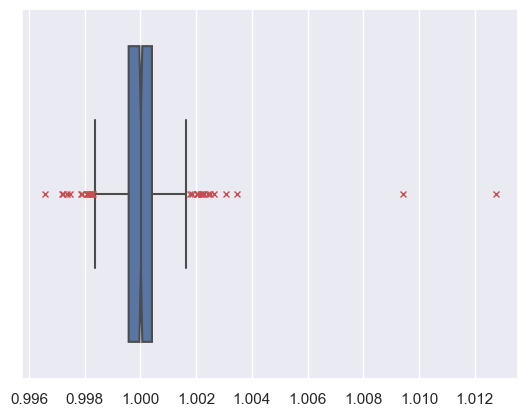

In [58]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


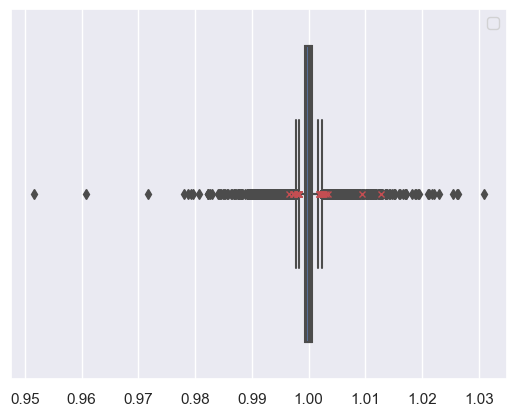

In [59]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

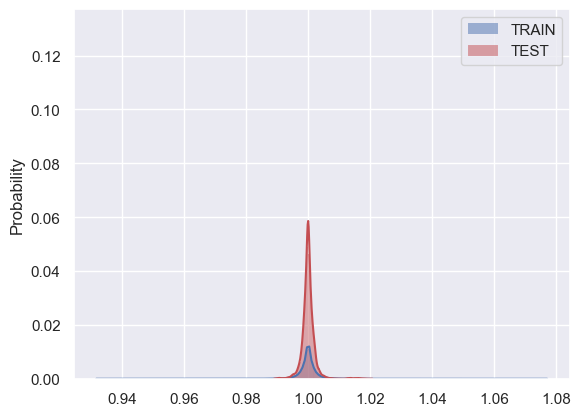

In [60]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [61]:
X_train_sca.shape

(60932, 12, 104)

In [62]:
X_train_sca[:,-1,:].shape

(60932, 104)

In [63]:
y_train_sca[:,0][:, np.newaxis]

array([[-0.01395759],
       [ 0.30030604],
       [-0.07752394],
       ...,
       [ 0.02486644],
       [-0.22635275],
       [ 0.18060658]])

In [64]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(60932, 105)

In [65]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [66]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [67]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

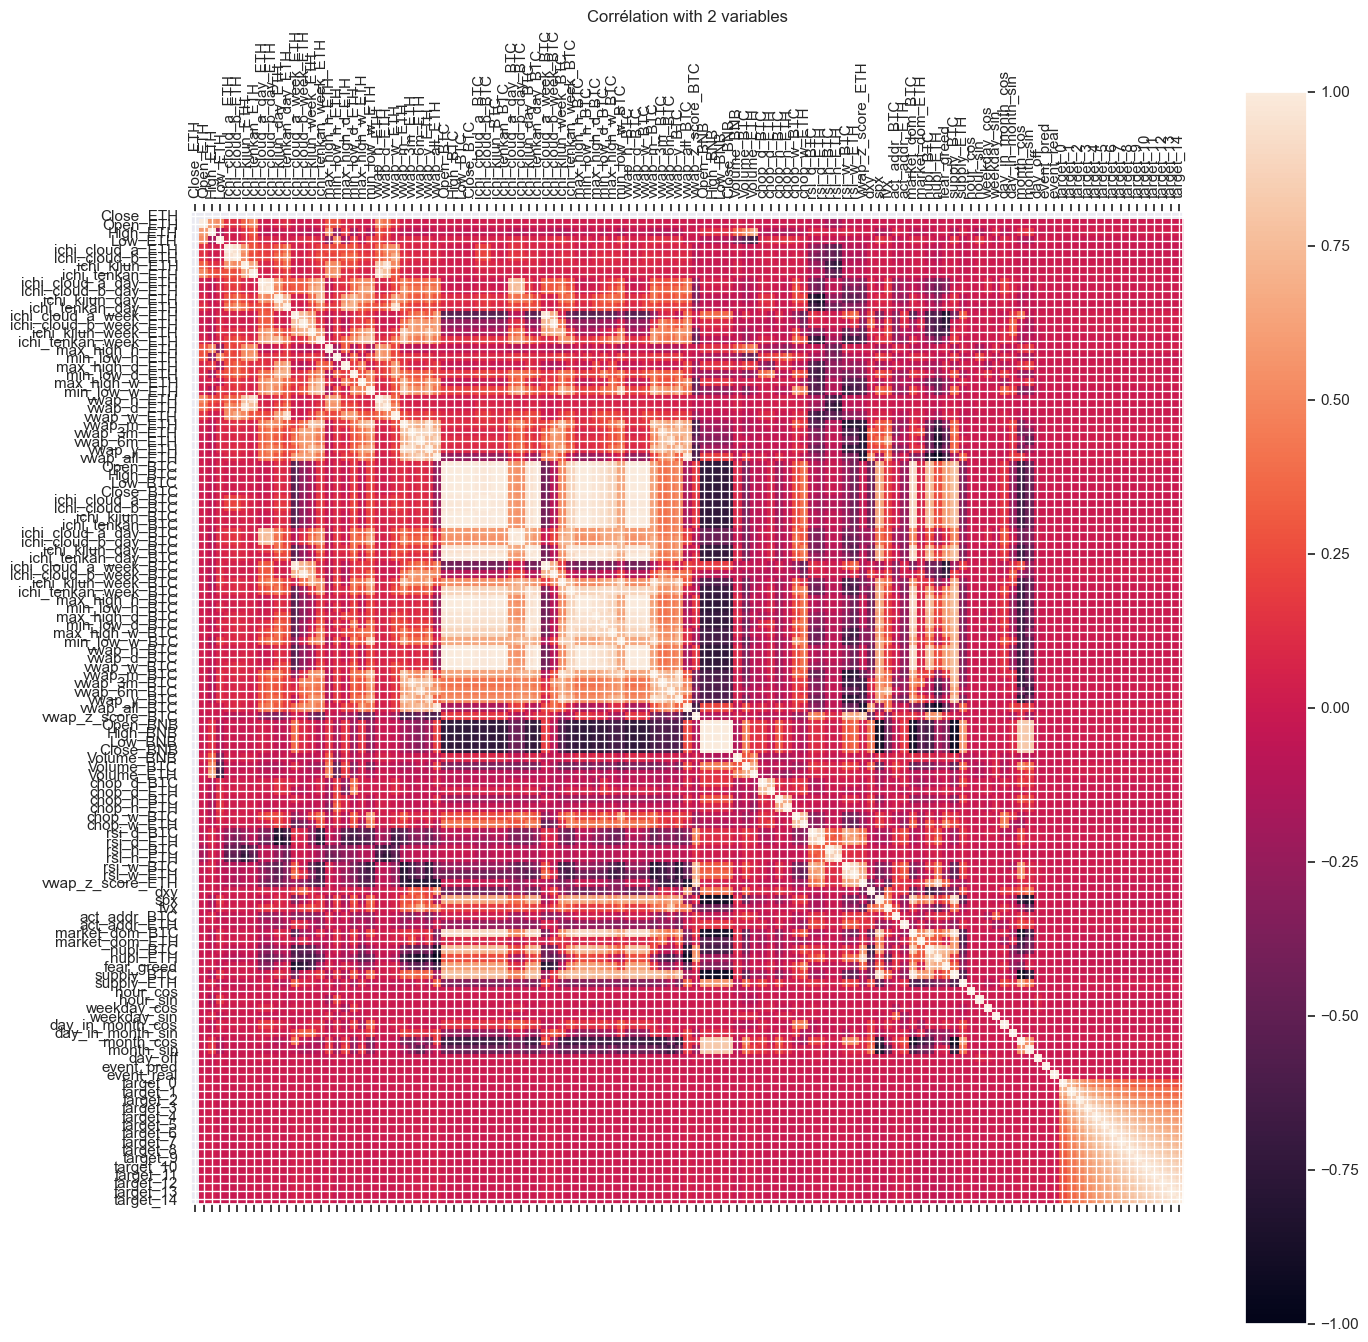

In [68]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


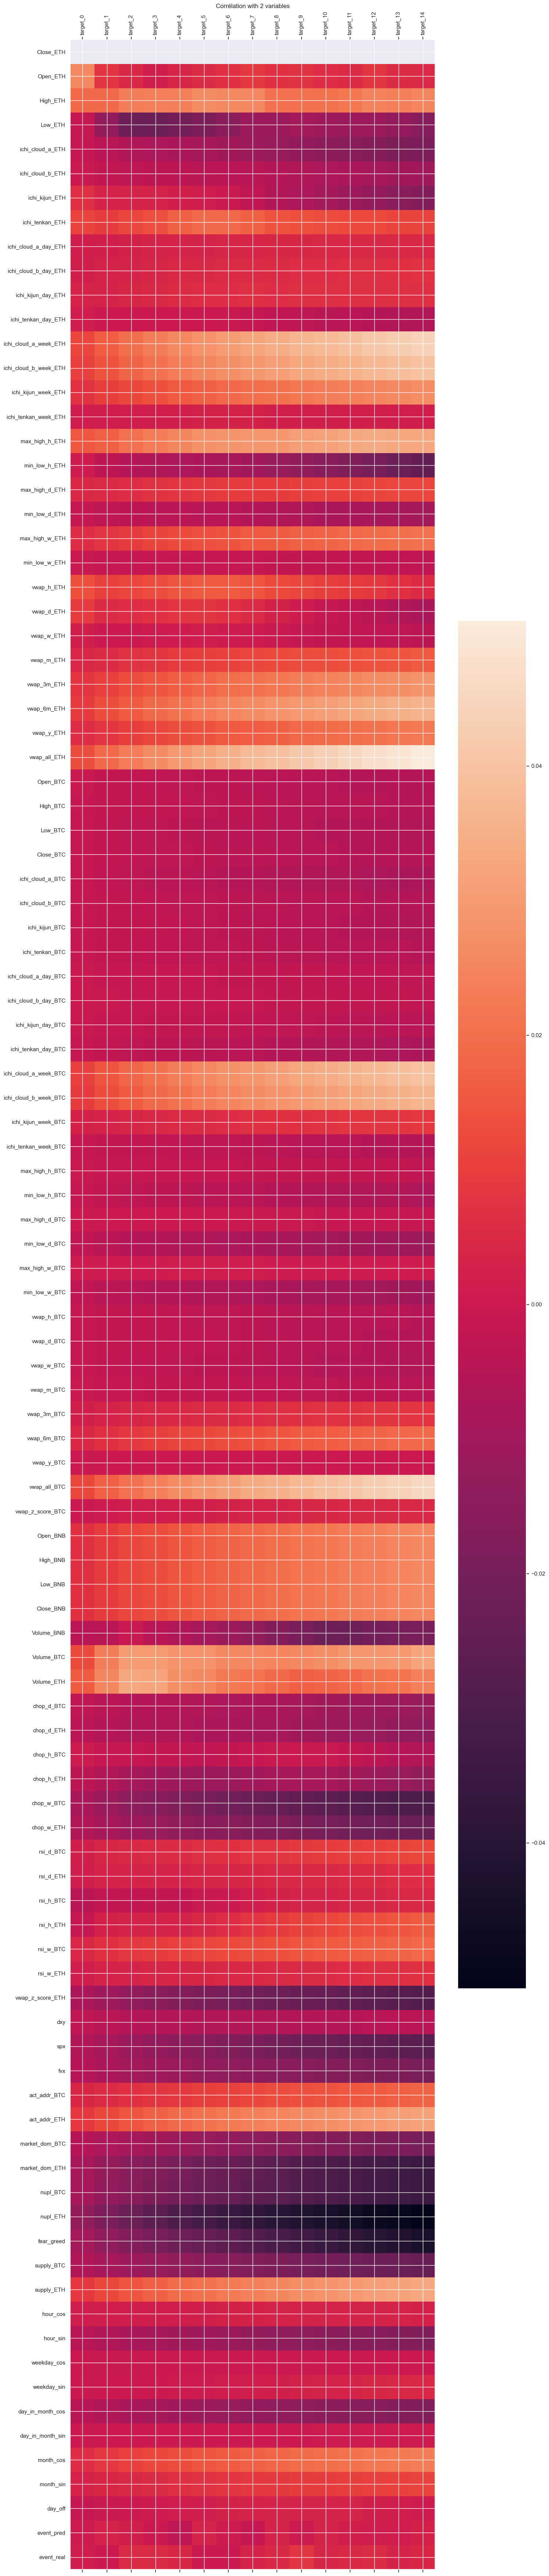

In [69]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


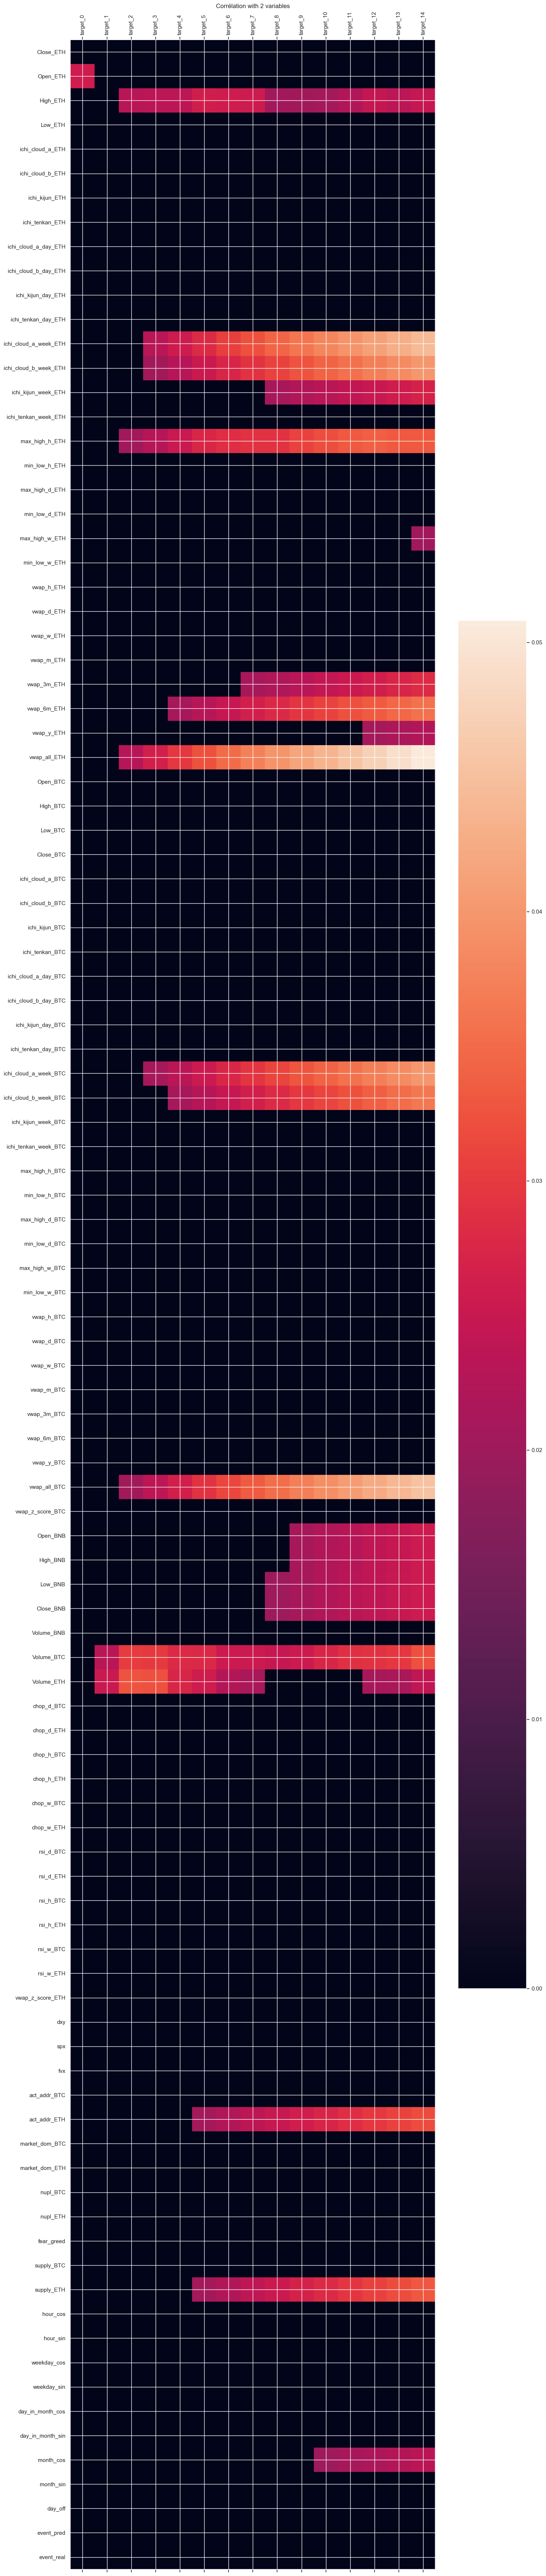

In [70]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [71]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

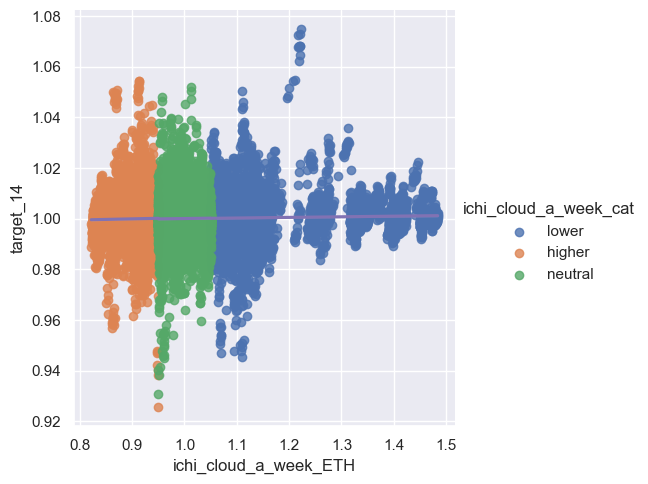

In [72]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

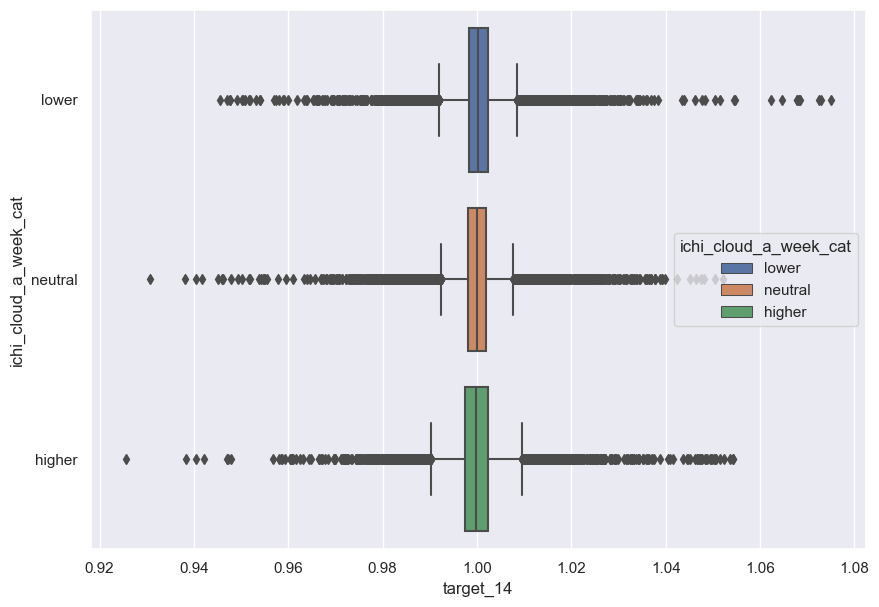

In [73]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [74]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


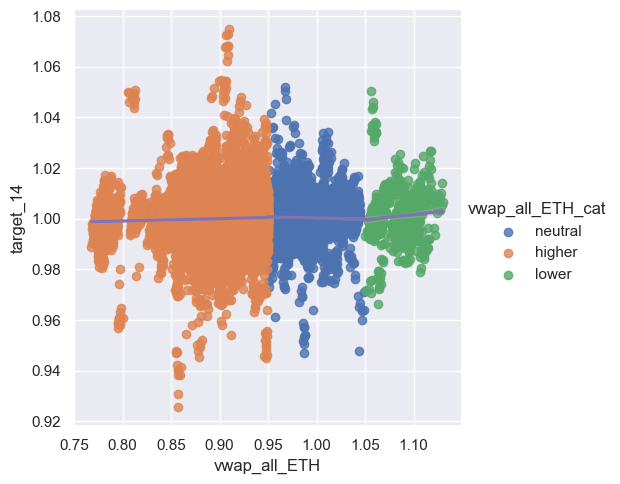

In [75]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

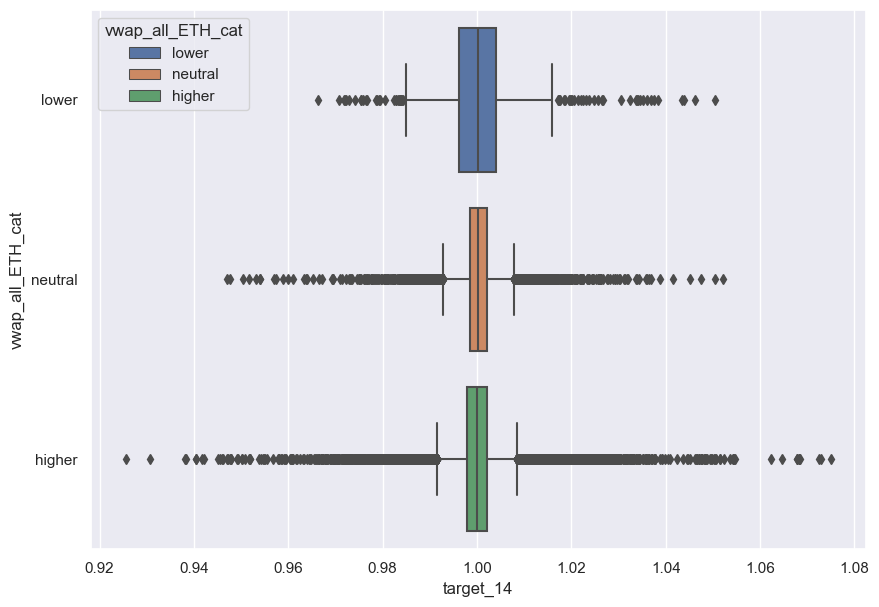

In [76]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

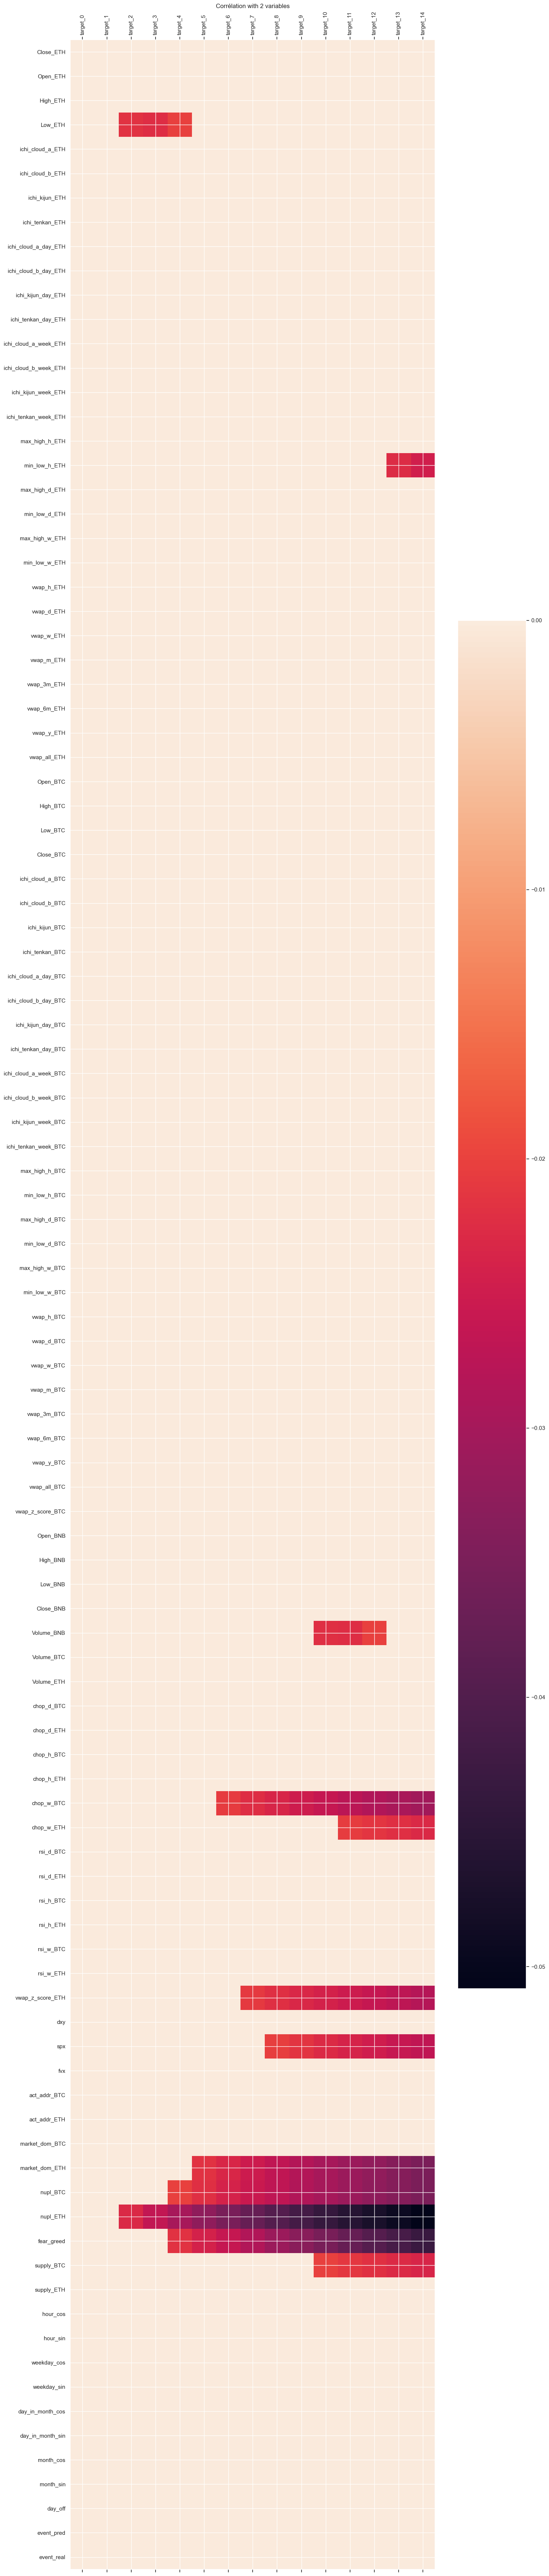

In [77]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

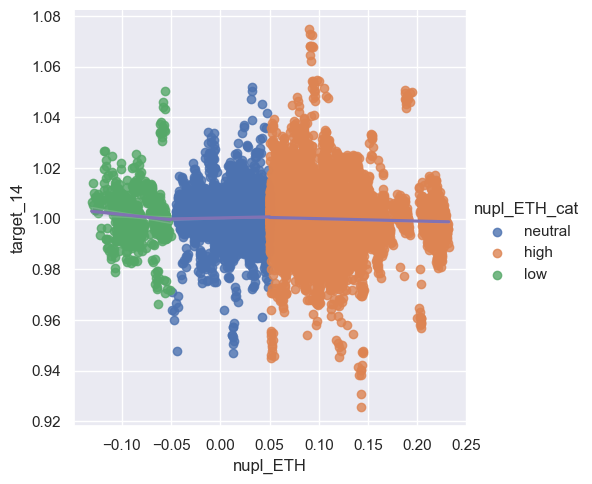

In [78]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

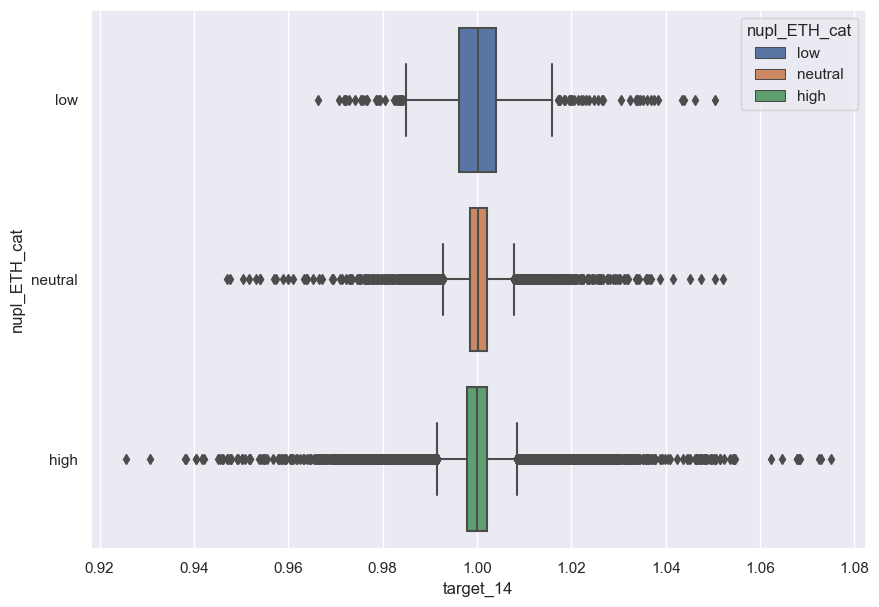

In [79]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [80]:
df["target_14"].describe()

count    60932.000000
mean         1.000126
std          0.005749
min          0.925613
25%          0.998002
50%          1.000032
75%          1.002162
max          1.074927
Name: target_14, dtype: float64

In [81]:
df["target_1"].describe()

count    60932.000000
mean         1.000017
std          0.002104
min          0.967271
25%          0.999217
50%          1.000006
75%          1.000807
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

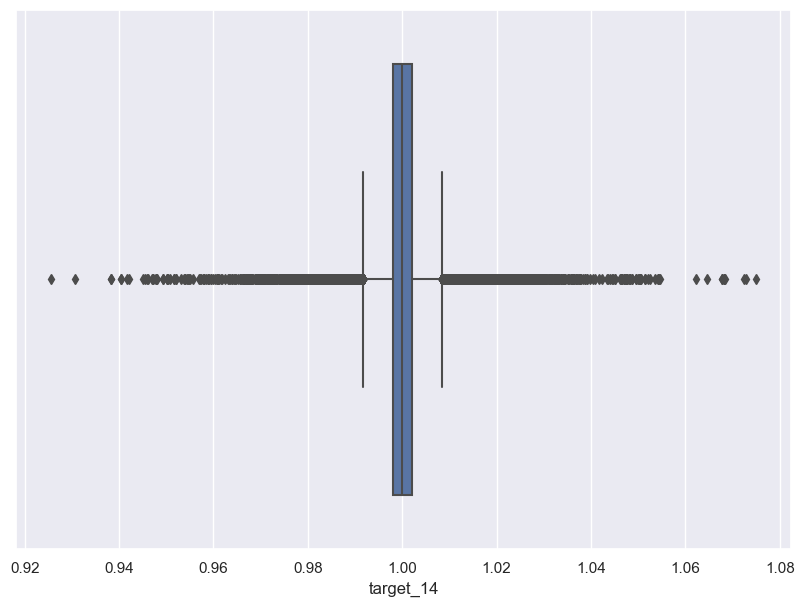

In [82]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [83]:
y_train

array([[1.00000837, 1.00133993, 1.00108032, ..., 1.00010049, 1.00023449,
        1.00094633],
       [1.00133155, 1.00107194, 1.00107194, ..., 1.00022611, 1.00093794,
        1.00103006],
       [0.99974074, 0.99974074, 0.99992473, ..., 0.99960692, 0.99969892,
        0.99974074],
       ...,
       [1.00017184, 0.99928579, 1.00011277, ..., 0.99845882, 0.99843197,
        0.99870584],
       [0.99911411, 0.99994094, 1.00078925, ..., 0.99826043, 0.99853425,
        0.99736917],
       [1.00082757, 1.00167663, 1.001107  , ..., 0.99941963, 0.99825351,
        0.99890912]])

In [84]:
y_train_sca

array([[-0.01395759,  0.30229771,  0.24063787, ...,  0.00792171,
         0.03974614,  0.20881344],
       [ 0.30030604,  0.23864671,  0.23864671, ...,  0.03775667,
         0.20682255,  0.22870166],
       [-0.07752394, -0.07752394, -0.0338239 , ..., -0.10930579,
        -0.08745577, -0.07752394],
       ...,
       [ 0.02486644, -0.18557586,  0.01083695, ..., -0.38198867,
        -0.38836571, -0.32331991],
       [-0.22635275, -0.02997369,  0.17150613, ..., -0.42910776,
        -0.36407314, -0.64078909],
       [ 0.18060658,  0.38226505,  0.24697519, ..., -0.15378911,
        -0.43075042, -0.27503945]])

## Autoencoder

### Model creation

### Training

In [85]:
X_train_sca.shape

(60932, 12, 104)

In [86]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 35 #100 #150 #6 #300
patience = 0 #20 #40 #3 #100
for n_unit_enc in [64]: #[104]: #
    for encoding_dim in [32]:
        for dropout_autoenc in [0.1]: #[0.25]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            path_jpg = os.path.join(path_data,
                f"output_MSE autoencoder - {plt_name}.jpg")
            if (MODE_TRAIN_AE == False):
                print(f"BE CAREFUL ! training inactivated => no training done...")
                continue
            print(f"Training: {plt_name} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.Dense(encoding_dim, activation='relu')
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            #decoder = layers.Dense(n_unit_enc, activation='relu')
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            optim = tf.keras.optimizers.legacy.Adam()
            autoencoder.compile(optimizer=optim, loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            if patience == 0:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1)
            else:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - {plt_name}",
                saveFolder=path_data)
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")

if MODE_TRAIN_AE:
    print("Save models...")
    autoencoder.save(path_mdl_autoencoder)
    encoder_model.save(path_mdl_encoder)
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())


BE CAREFUL ! training inactivated => no training done...
Load models...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 model (Functional)          (None, None, 32)          45344     
                                                                 
 model_1 (Functional)        (None, None, 104)         31592     
                                                                 
Total params: 76,936
Trainable params: 76,936
Non-trainable params: 0
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (Inp

In [88]:
encoder_model

In [91]:
#encoder_outputs = layers.Dense(encoding_dim)(encoder_model)

### Save model

In [92]:
# TODO select best model


In [93]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [94]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [95]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2023-08-03 01:47:48.560148: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  13/1905 [..............................] - ETA: 16s 

1905/1905 [==============================] - 17s 8ms/step


(60932, 12, 104)

### Results

In [96]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

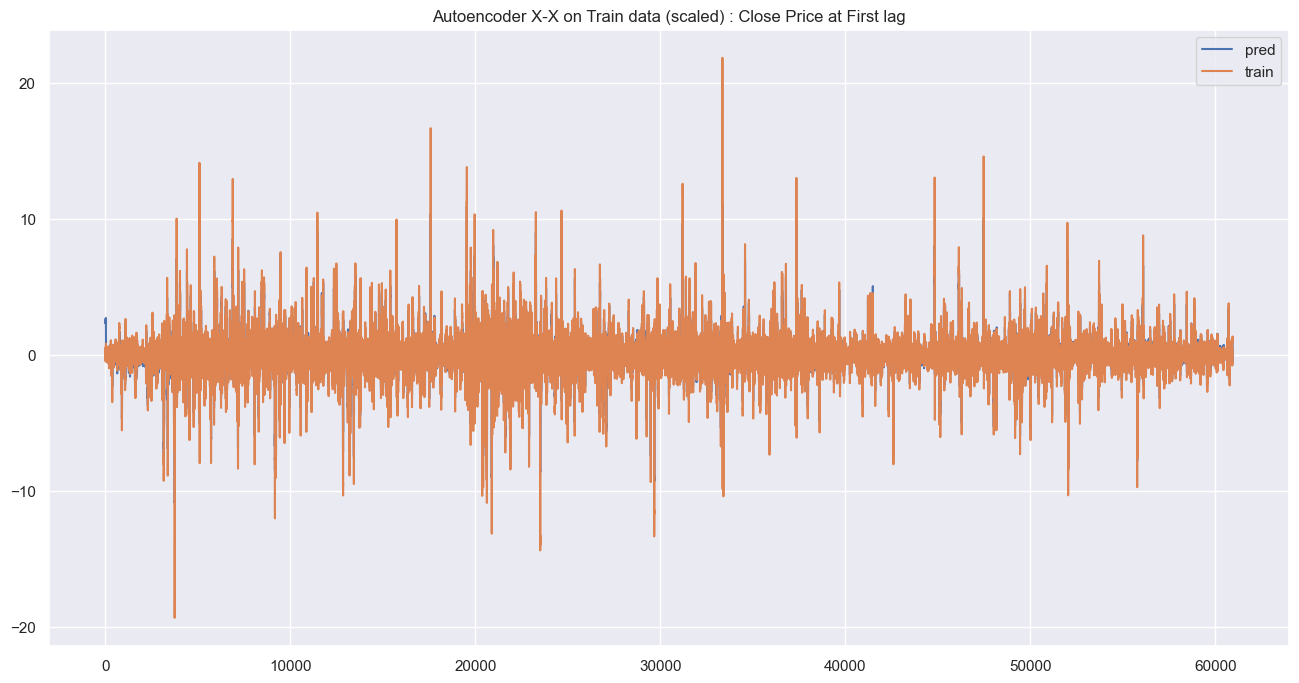

In [97]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE by lags and by features

In [98]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)
df_mae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_train.index))]
df_mae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(60932, 12, 104)
(60932, 12, 104)
(12, 104)
(1, 104)


In [99]:
df_mae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.222210  0.244282  0.192234  0.199582          0.154963   
lag_1    0.190291  0.196198  0.167124  0.170853          0.138239   
lag_2    0.176579  0.178055  0.151672  0.156239          0.136214   
lag_3    0.171087  0.173005  0.147791  0.150517          0.133556   
lag_4    0.164083  0.169652  0.142321  0.145611          0.132728   
lag_5    0.158610  0.167855  0.139084  0.142066          0.131856   
lag_6    0.151740  0.165555  0.134522  0.137611          0.131556   
lag_7    0.145018  0.163529  0.130341  0.133288          0.130881   
lag_8    0.137596  0.161226  0.125205  0.128453          0.130663   
lag_9    0.129393  0.159053  0.120048  0.123297          0.130251   
lag_10   0.120390  0.156381  0.114249  0.117661          0.130054   
lag_11   0.107577  0.154593  0.106918  0.110964          0.129833   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.166277        0.213434         0.218965   
lag_1           0.150702        0.196284         0.203266   
lag_2           0.144547        0.187666         0.187948   
lag_3           0.141810        0.181575         0.178035   
lag_4           0.139320        0.176606         0.169238   
lag_5           0.137888        0.173237         0.162918   
lag_6           0.136481        0.169604         0.157091   
lag_7           0.135255        0.166145         0.152229   
lag_8           0.134299        0.162712         0.147917   
lag_9           0.133401        0.159445         0.144919   
lag_10          0.132593        0.155900         0.142602   
lag_11          0.131893        0.152129         0.140674   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
lag_0               0.142271              0.130813  ...  0.214337   
lag_1               0.128256              0.117470  ...  0.159657   
lag_2               0.119643              0.110092  ...  0.151158   
lag_3               0.116869              0.106918  ...  0.152817   
lag_4               0.115319              0.105717  ...  0.151955   
lag_5               0.115519              0.105883  ...  0.151900   
lag_6               0.115464              0.105971  ...  0.151117   
lag_7               0.115859              0.106454  ...  0.150271   
lag_8               0.116031              0.106704  ...  0.149468   
lag_9               0.116276              0.107028  ...  0.148632   
lag_10              0.116229              0.107131  ...  0.147860   
lag_11              0.116144              0.107186  ...  0.147014   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.216767     0.221380          0.221042          0.186392   
lag_1      0.177315     0.177306          0.169448          0.157630   
lag_2      0.153883     0.163415          0.141517          0.133848   
lag_3      0.148602     0.162731          0.133738          0.123651   
lag_4      0.145098     0.161894          0.129064          0.117129   
lag_5      0.144141     0.161574          0.126963          0.113100   
lag_6      0.142850     0.161222          0.126130          0.110295   
lag_7      0.142190     0.160948          0.125312          0.108050   
lag_8      0.141236     0.160738          0.124894          0.106447   
lag_9      0.140438     0.160581          0.124046          0.104837   
lag_10     0.139591     0.160299          0.123243          0.103517   
lag_11     0.138713     0.160119          0.122075          0.102212   

        month_cos  month_sin   day_off  event_pred  event_real  
lag_0    0.128309   0.175051  0.093537    0.219043    0.236408  
lag_1    0.111752   0.149119  0.063560    0.134153    0.139239  
lag_2    0.106319   0.138836  0.054538    0.087065    0.090151  
lag_3    0.104500   0.135113  0.053077    0.081683    0.079886  
lag_4    0.104603   0.133741  0.053715    0.074350    0.076665  
lag_5    0.105071   0.133097  0.054371    0.072410    0.074456  
lag_6    0.105531   0.1328

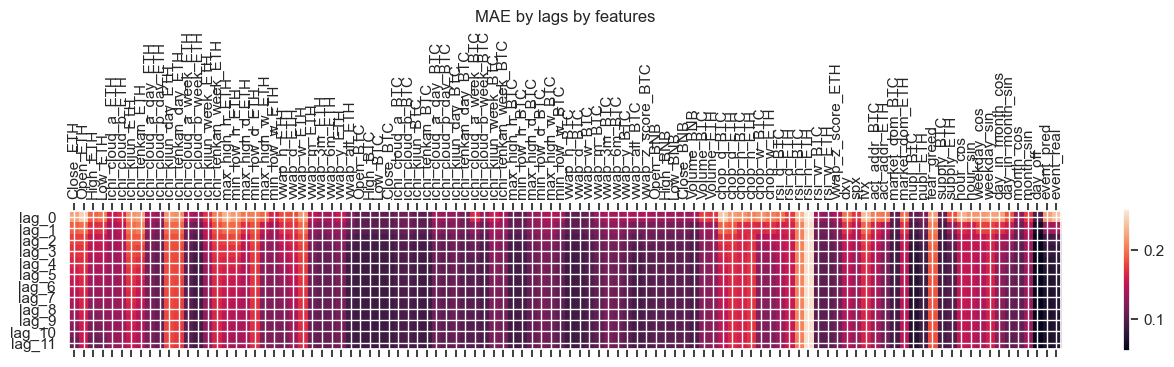

In [100]:
plot_corr(df_mae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

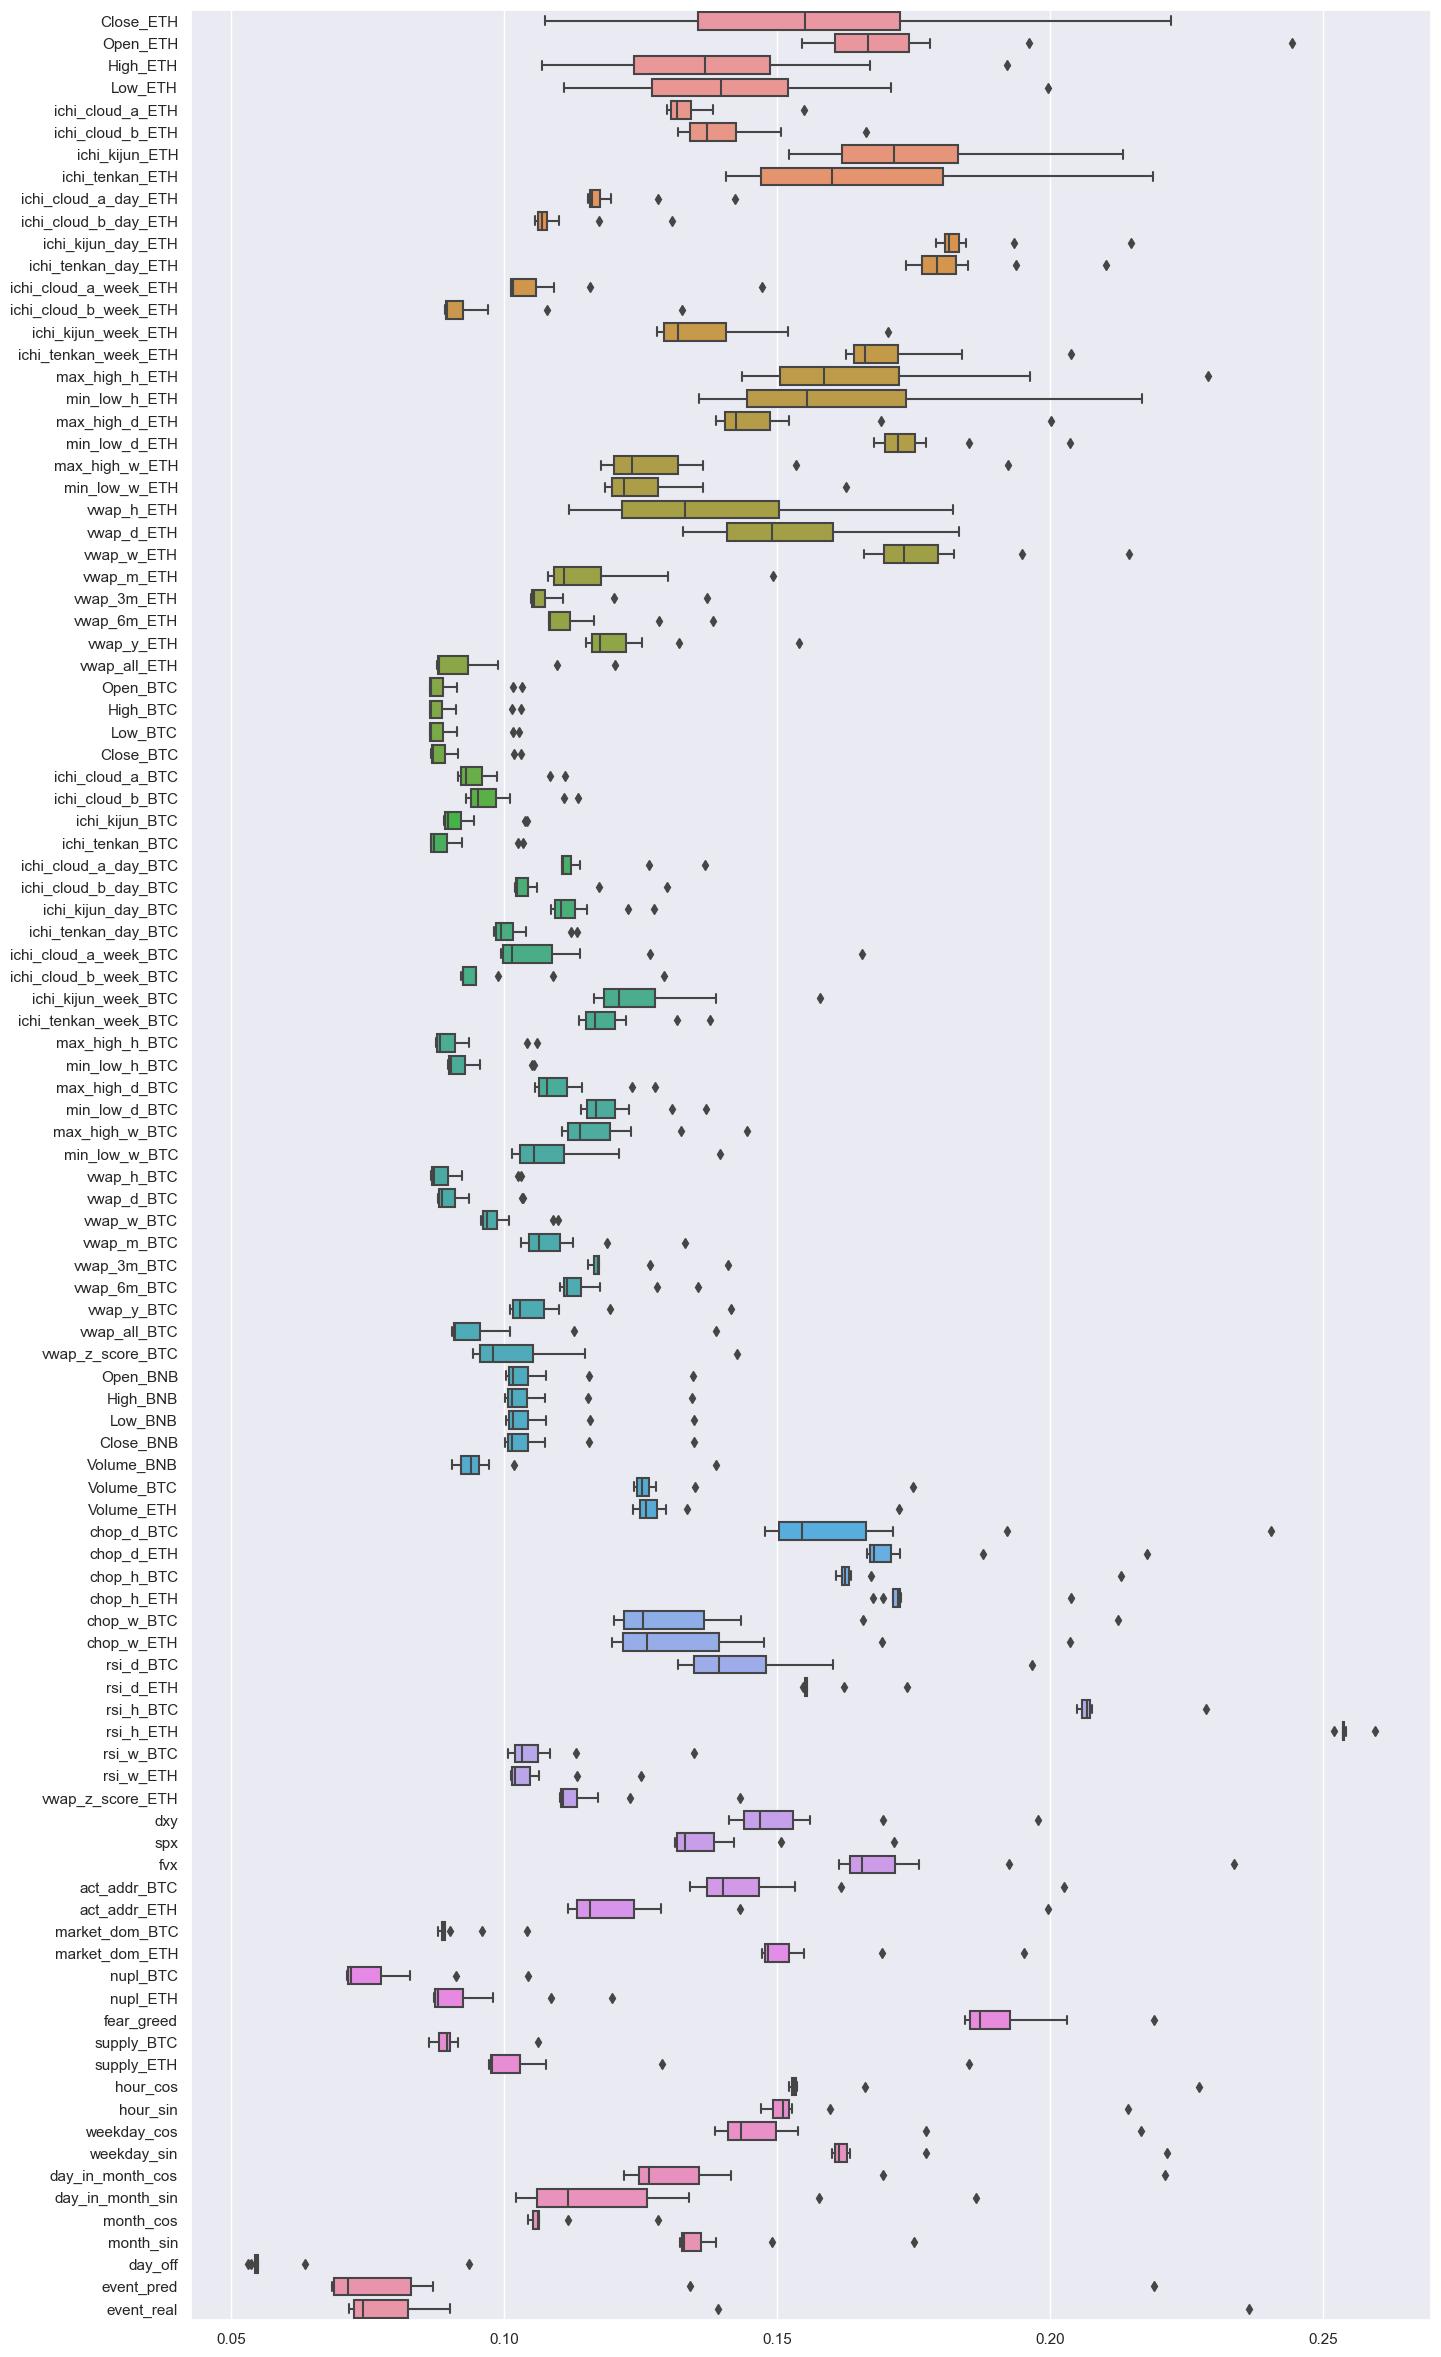

In [101]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_train, orient="h")

In [102]:
df_mae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.156214  0.174116  0.139292  0.143012          0.134233   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.140372        0.174561          0.16715               0.11949   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.109781  ...  0.156349     0.152569     0.167684   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin   day_off  \
0          0.138956          0.122259   0.108105   0.138356  0.058512   

   event_pred  event_real  
0    0.090295    0.094355  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature')

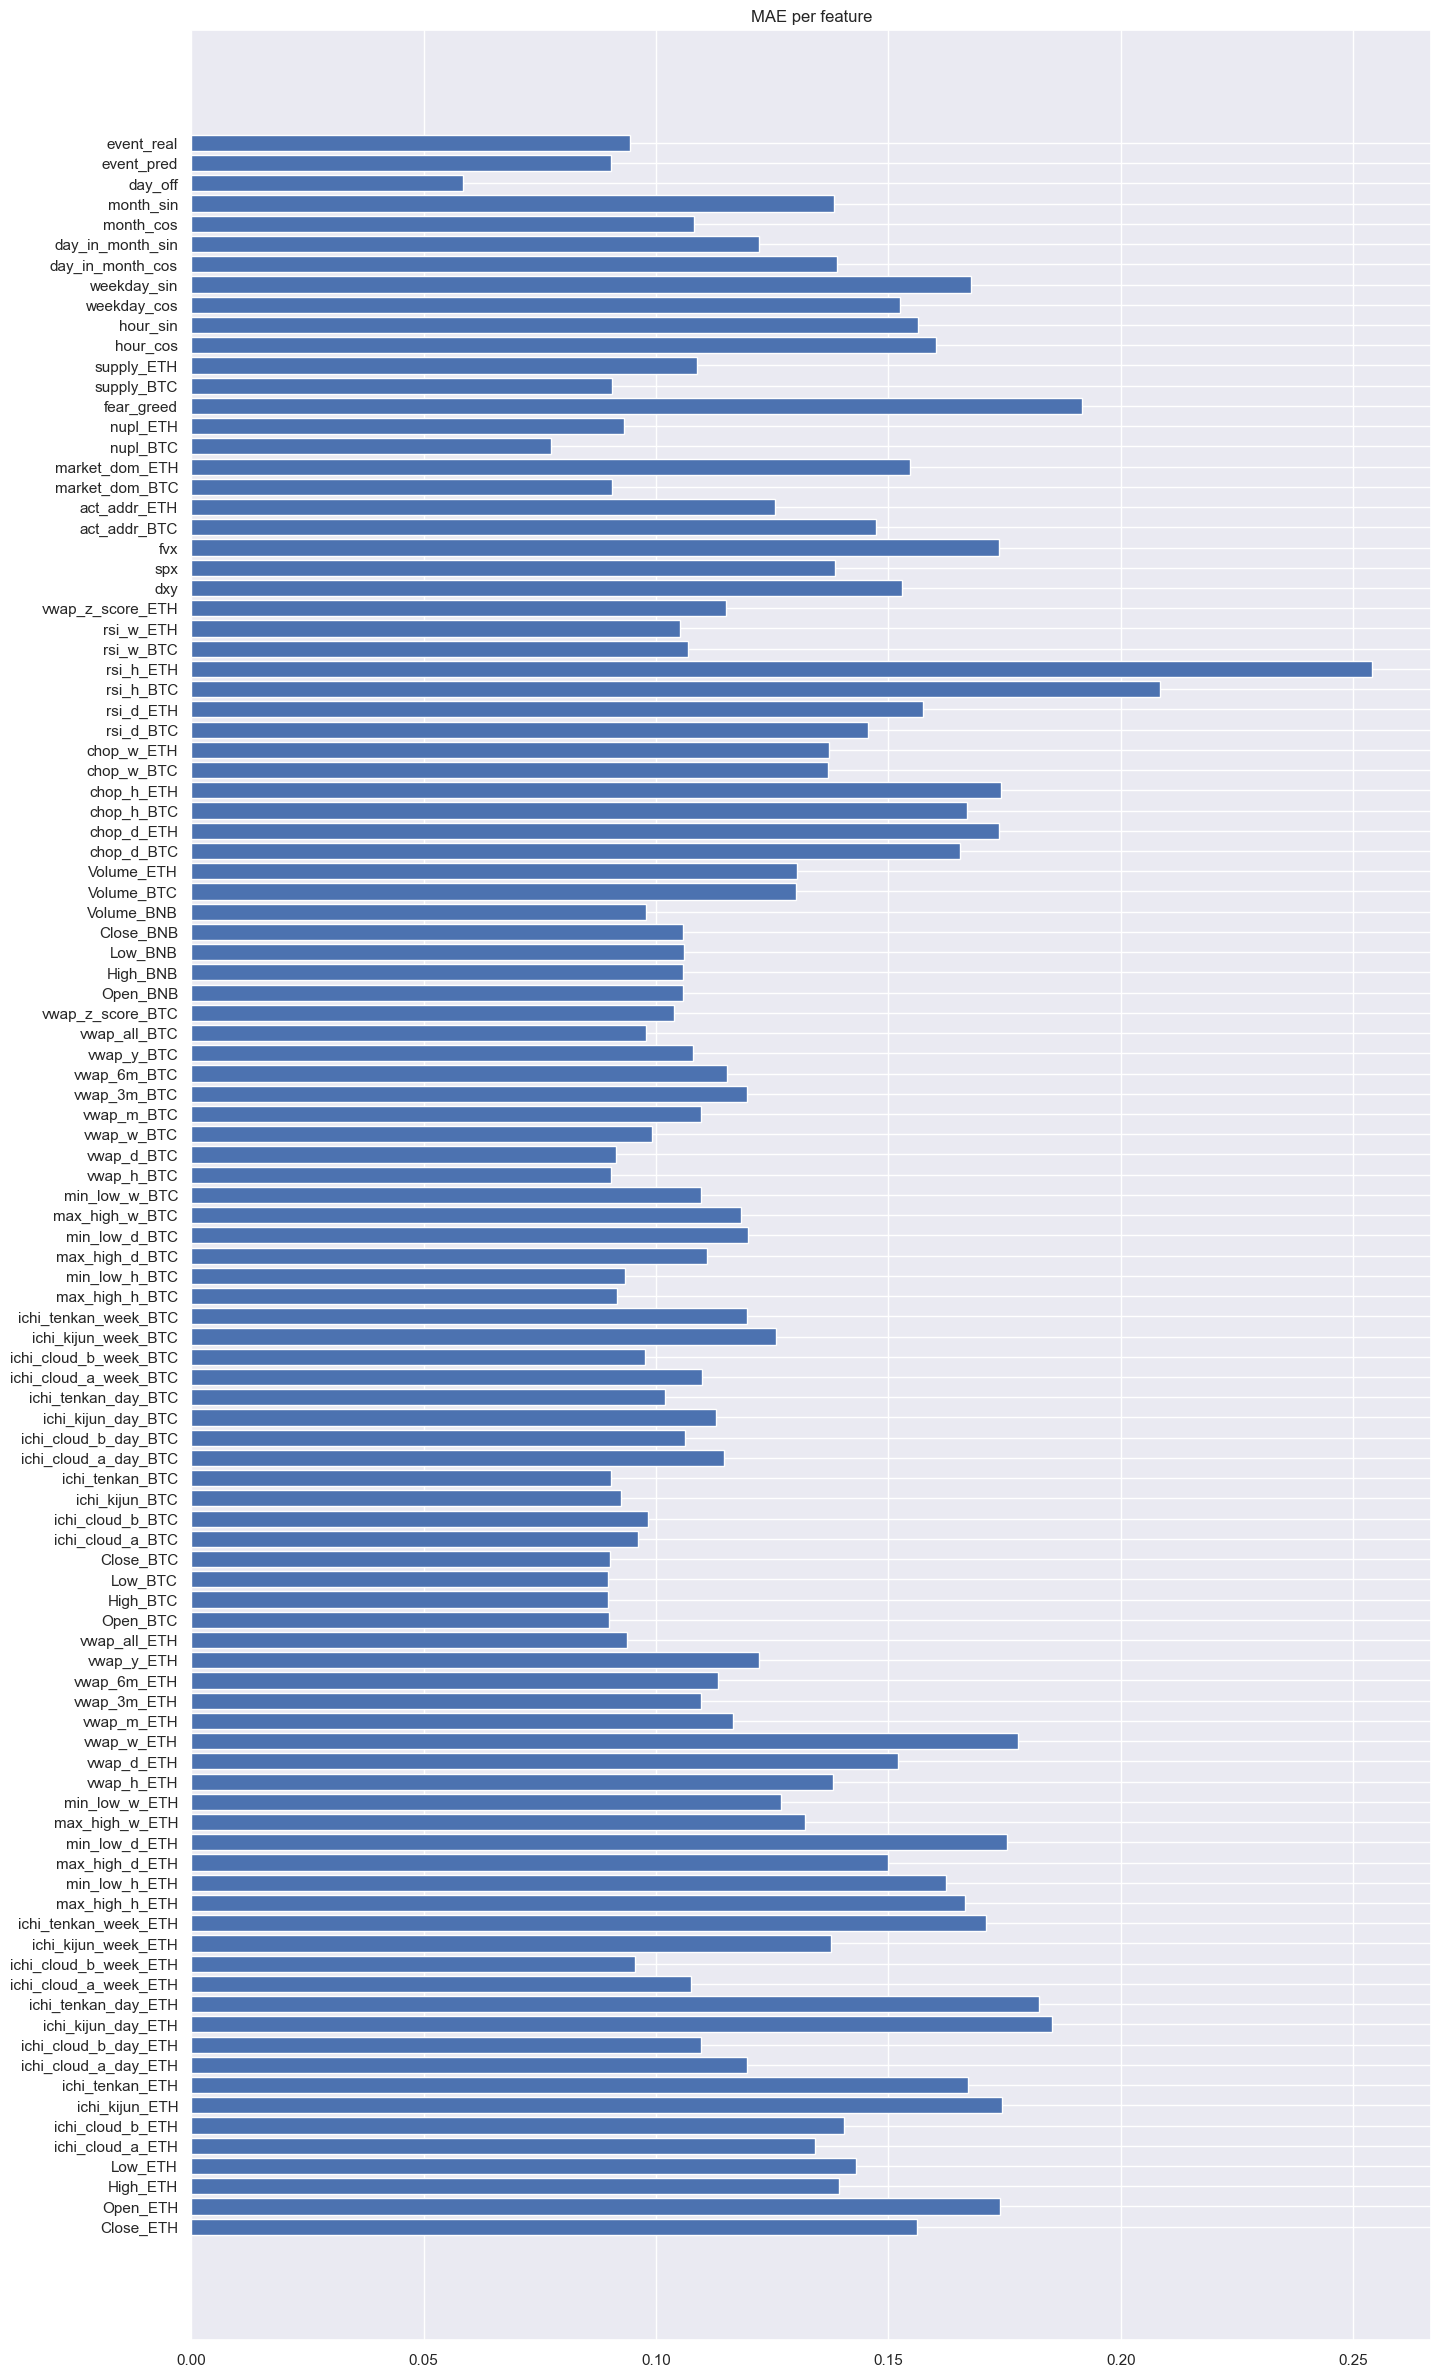

In [103]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_train_feat.columns, df_mae_train_feat.values[0])
plt.title("MAE per feature")

In [104]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(60932,)
(60932,)
[1196.32 1195.38 1194.55 ... 1870.2  1868.82 1868.4 ]
[1196.32 1195.38 1194.55]


In [105]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.99838954, 0.99836427, 0.99820846, ..., 1.0004466 , 1.000285  ,
       1.0006752 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1870.2  1868.82 1868.4 ]
[1204.01084772 1204.03061045 1205.42786705 ... 1869.42698369 1868.69402124
 1867.00084877]


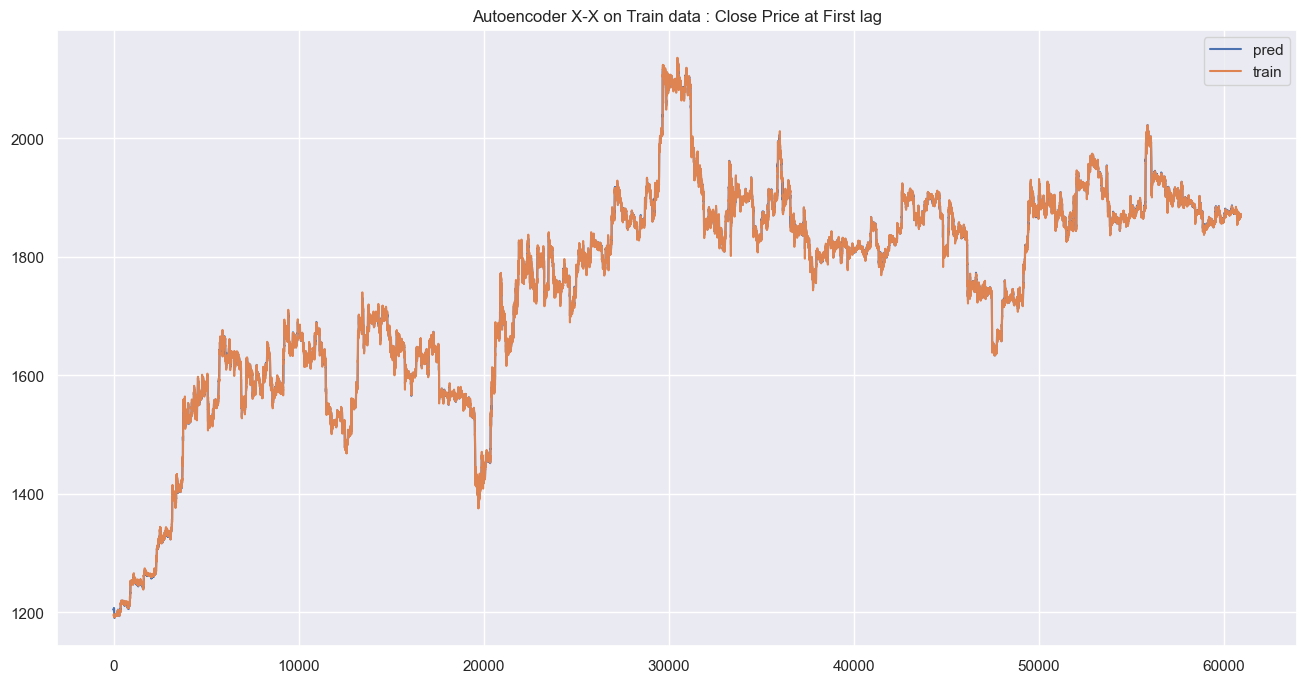

In [106]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [107]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

 1/21 [>.............................] - ETA: 0s

21/21 [==============================] - 0s 10ms/step


(644, 12, 104)

In [108]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-31 15:50:00'

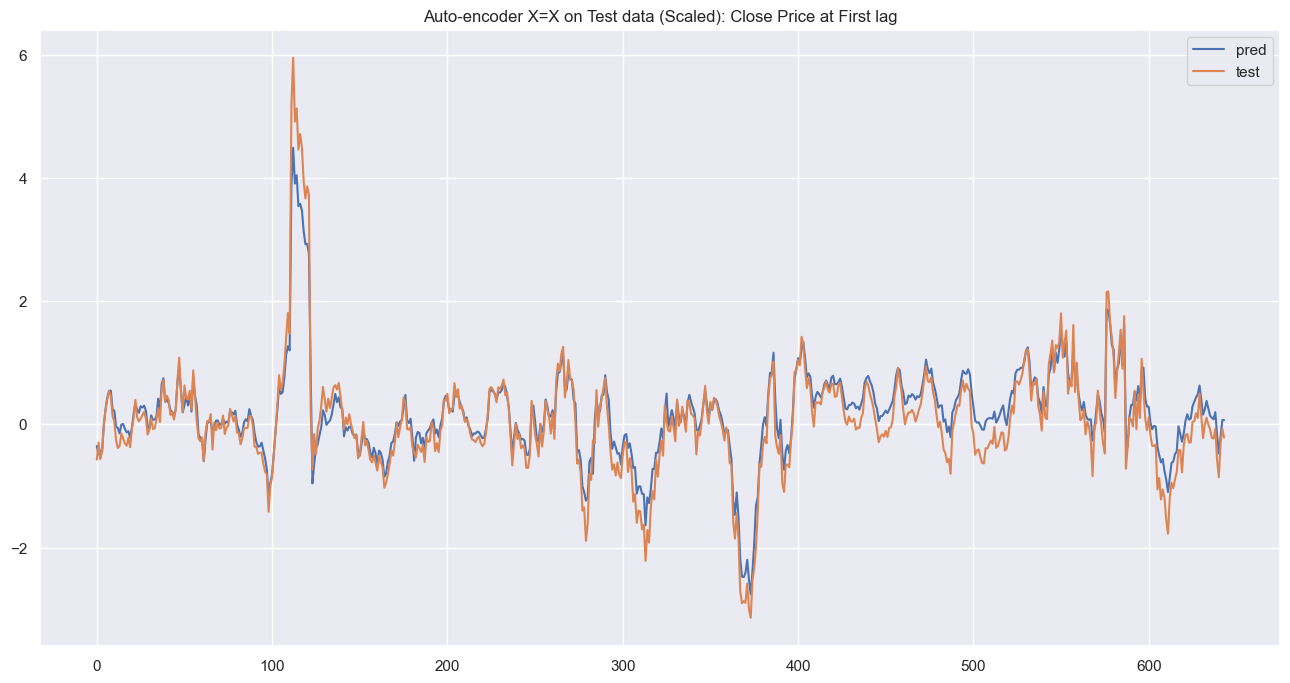

In [109]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [110]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1857.37 1857.88 1856.01 1857.43 1859.45 1860.04 1860.17 1860.78 1860.54]
X test pred :  [1858.7898965  1856.62632738 1856.9102431  1857.40256121 1859.31926705
 1860.07378856 1860.36705381 1860.77598553 1861.12487265]


[1857.37 1857.88 1856.01 1857.43 1859.45 1860.04 1860.17 1860.78 1860.54
 1860.94 1861.2  1861.15 1859.87 1859.74 1860.37 1859.47 1858.53 1857.58
 1857.32 1857.63 1860.14 1860.95 1862.94 1862.43 1862.11 1861.4  1861.03
 1860.59 1859.9  1858.8  1860.1  1860.75 1860.32 1860.42 1861.72 1861.86
 1860.86 1860.13 1859.33 1859.32 1859.94 1860.69 1860.2  1860.88 1860.9
 1861.31 1860.24 1860.68 1856.49 1854.75 1856.97 1857.   1858.2  1859.27
 1859.67 1860.46 1859.81 1855.74 1853.73 1853.24 1853.51 1852.94 1854.33
 1855.63 1855.8  1858.2  1854.86 1856.95 1855.49 1855.26 1855.08 1854.95
 1856.87 1855.31 1855.33 1855.6  1857.18 1857.58 1856.81 1856.18 1855.15
 1855.6  1855.36 1856.   1856.4  1855.7  1855.83 1855.62 1856.58 1856.58
 1855.35 1856.08 1856.6  1857.53 1857.52 1856.86 1856.14 1856.26 1854.84
 1855.75 1856.79 1857.78 1858.53 1859.78 1860.58 1860.57 1861.1  1861.19
 1861.64 1864.15 1862.27 1862.41 1860.96 1859.14 1857.68 1855.47 1857.04
 1856.74 1855.02 1852.57 1852.52 1852.8  1829.44 182

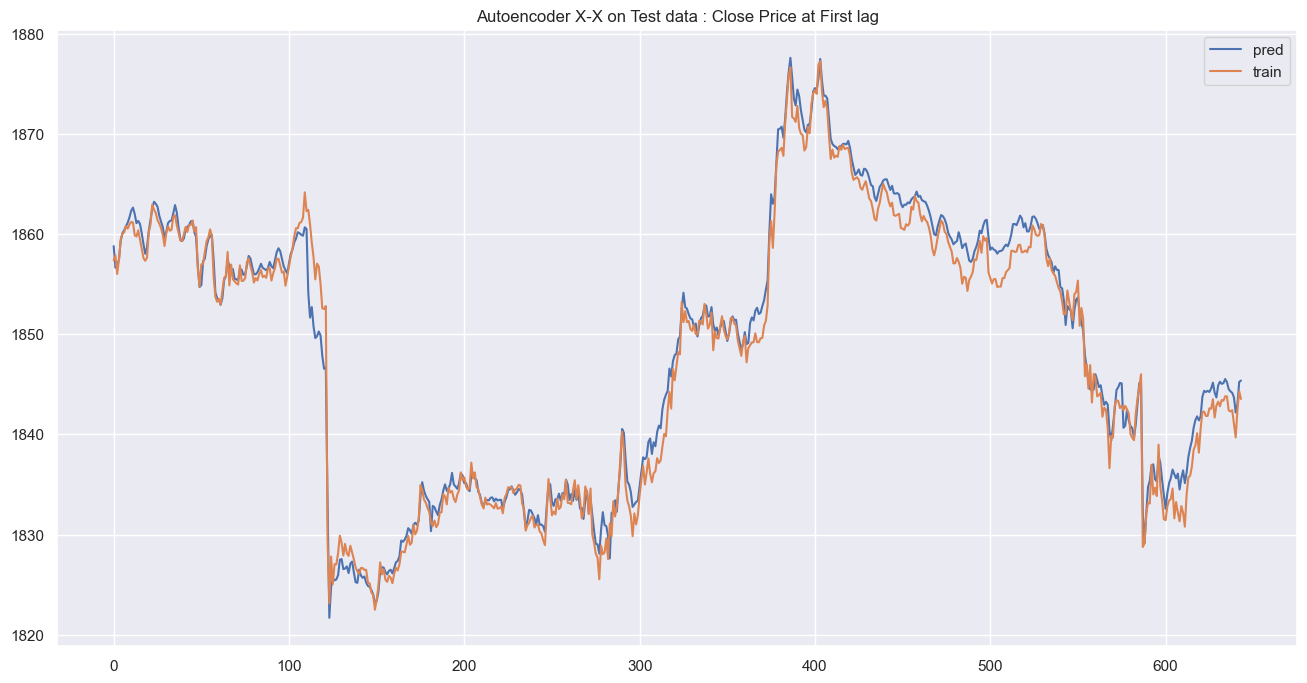

In [111]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [112]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(644, 12, 104)
(644, 12, 104)
(12, 104)
(1, 104)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.222210  0.244282  0.192234  0.199582          0.154963   
lag_1    0.190291  0.196198  0.167124  0.170853          0.138239   
lag_2    0.176579  0.178055  0.151672  0.156239          0.136214   
lag_3    0.171087  0.173005  0.147791  0.150517          0.133556   
lag_4    0.164083  0.169652  0.142321  0.145611          0.132728   
lag_5    0.158610  0.167855  0.139084  0.142066          0.131856   
lag_6    0.151740  0.165555  0.134522  0.137611          0.131556   
lag_7    0.145018  0.163529  0.130341  0.133288          0.130881   
lag_8    0.137596  0.161226  0.125205  0.128453          0.130663   
lag_9    0.129393  0.159053  0.120048  0.123297          0.130251   
lag_10   0.120390  0.156381  0.114249  0.117661          0.130054   
lag_11   0.107577  0.154593  0.106918  0.110964          0.129833   
lag_0    0.211108  0.297356  0.156457  0.178248          0.214782   
lag_1    0.182385  0.163519  0.138083  0.156618          0.162510   
lag_2    0.192599  0.142264  0.162309  0.162350          0.190703   
lag_3    0.172049  0.150194  0.155919  0.155864          0.182676   
lag_4    0.175296  0.160666  0.167512  0.159288          0.180115   
lag_5    0.162613  0.156514  0.158771  0.150337          0.178080   
lag_6    0.164382  0.160474  0.162939  0.151355          0.176944   
lag_7    0.155097  0.156442  0.155128  0.145076          0.176619   
lag_8    0.153782  0.158257  0.155270  0.144588          0.176126   
lag_9    0.147170  0.153618  0.148798  0.139351          0.175897   
lag_10   0.143295  0.152293  0.147102  0.137186          0.175480   
lag_11   0.133106  0.150256  0.141837  0.131364          0.175219   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.166277        0.213434         0.218965   
lag_1           0.150702        0.196284         0.203266   
lag_2           0.144547        0.187666         0.187948   
lag_3           0.141810        0.181575         0.178035   
lag_4           0.139320        0.176606         0.169238   
lag_5           0.137888        0.173237         0.162918   
lag_6           0.136481        0.169604         0.157091   
lag_7           0.135255        0.166145         0.152229   
lag_8           0.134299        0.162712         0.147917   
lag_9           0.133401        0.159445         0.144919   
lag_10          0.132593        0.155900         0.142602   
lag_11          0.131893        0.152129         0.140674   
lag_0           0.189535        0.182682         0.219578   
lag_1           0.137634        0.154969         0.202166   
lag_2           0.149851        0.158599         0.157199   
lag_3           0.144881        0.148410         0.155064   
lag_4           0.140878        0.157289         0.145337   
lag_5           0.141774        0.146553         0.138724   
lag_6           0.139648        0.150970         0.137048   
lag_7           0.140358        0.144147         0.130367   
lag_8           0.139228        0.146767         0.130291   
lag_9           0.139828        0.139760         0.124465   
lag_10          0.139161        0.139044         0.123795   
lag_11          0.139559        0.131675         0.118946   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.142271              0.130813  ...     0.216767   
lag_1               0.128256              0.117470  ...     0.177315   
lag_2               0.119643              0.110092  ...     0.153883   
lag_3               0.116869              0.106918  ...     0.148602   
lag_4               0.115319              0.105717  ...     0.145098   
lag_5               0.115519              0.105883  ...     0.144141   
lag_6               0.115464              0.105971  ...     0.142850   
lag_7               0.115859              0.106454  ...     0.142190   
lag_8               0.116031              0.106704  ...     0.141236   
lag_9               0.116276        

In [113]:
df_mae_ae_comp

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.222210  0.244282  0.192234  0.199582          0.154963   
lag_1    0.190291  0.196198  0.167124  0.170853          0.138239   
lag_2    0.176579  0.178055  0.151672  0.156239          0.136214   
lag_3    0.171087  0.173005  0.147791  0.150517          0.133556   
lag_4    0.164083  0.169652  0.142321  0.145611          0.132728   
lag_5    0.158610  0.167855  0.139084  0.142066          0.131856   
lag_6    0.151740  0.165555  0.134522  0.137611          0.131556   
lag_7    0.145018  0.163529  0.130341  0.133288          0.130881   
lag_8    0.137596  0.161226  0.125205  0.128453          0.130663   
lag_9    0.129393  0.159053  0.120048  0.123297          0.130251   
lag_10   0.120390  0.156381  0.114249  0.117661          0.130054   
lag_11   0.107577  0.154593  0.106918  0.110964          0.129833   
lag_0    0.211108  0.297356  0.156457  0.178248          0.214782   
lag_1    0.182385  0.163519  0.138083  0.156618          0.162510   
lag_2    0.192599  0.142264  0.162309  0.162350          0.190703   
lag_3    0.172049  0.150194  0.155919  0.155864          0.182676   
lag_4    0.175296  0.160666  0.167512  0.159288          0.180115   
lag_5    0.162613  0.156514  0.158771  0.150337          0.178080   
lag_6    0.164382  0.160474  0.162939  0.151355          0.176944   
lag_7    0.155097  0.156442  0.155128  0.145076          0.176619   
lag_8    0.153782  0.158257  0.155270  0.144588          0.176126   
lag_9    0.147170  0.153618  0.148798  0.139351          0.175897   
lag_10   0.143295  0.152293  0.147102  0.137186          0.175480   
lag_11   0.133106  0.150256  0.141837  0.131364          0.175219   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.166277        0.213434         0.218965   
lag_1           0.150702        0.196284         0.203266   
lag_2           0.144547        0.187666         0.187948   
lag_3           0.141810        0.181575         0.178035   
lag_4           0.139320        0.176606         0.169238   
lag_5           0.137888        0.173237         0.162918   
lag_6           0.136481        0.169604         0.157091   
lag_7           0.135255        0.166145         0.152229   
lag_8           0.134299        0.162712         0.147917   
lag_9           0.133401        0.159445         0.144919   
lag_10          0.132593        0.155900         0.142602   
lag_11          0.131893        0.152129         0.140674   
lag_0           0.189535        0.182682         0.219578   
lag_1           0.137634        0.154969         0.202166   
lag_2           0.149851        0.158599         0.157199   
lag_3           0.144881        0.148410         0.155064   
lag_4           0.140878        0.157289         0.145337   
lag_5           0.141774        0.146553         0.138724   
lag_6           0.139648        0.150970         0.137048   
lag_7           0.140358        0.144147         0.130367   
lag_8           0.139228        0.146767         0.130291   
lag_9           0.139828        0.139760         0.124465   
lag_10          0.139161        0.139044         0.123795   
lag_11          0.139559        0.131675         0.118946   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.142271              0.130813  ...     0.216767   
lag_1               0.128256              0.117470  ...     0.177315   
lag_2               0.119643              0.110092  ...     0.153883   
lag_3               0.116869              0.106918  ...     0.148602   
lag_4               0.115319              0.105717  ...     0.145098   
lag_5               0.115519              0.105883  ...     0.144141   
lag_6               0.115464              0.105971  ...     0.142850   
lag_7               0.115859              0.106454  ...     0.142190   
lag_8               0.116031              0.106704  ...     0.141236   
lag_9               0.116276        

In [114]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0      TRAIN   Close_ETH  0.222210
1      TRAIN   Close_ETH  0.190291
2      TRAIN   Close_ETH  0.176579
3      TRAIN   Close_ETH  0.171087
4      TRAIN   Close_ETH  0.164083
...      ...         ...       ...
2491    TEST  event_real  0.080036
2492    TEST  event_real  0.079918
2493    TEST  event_real  0.078593
2494    TEST  event_real  0.078474
2495    TEST  event_real  0.077445

[2496 rows x 3 columns]

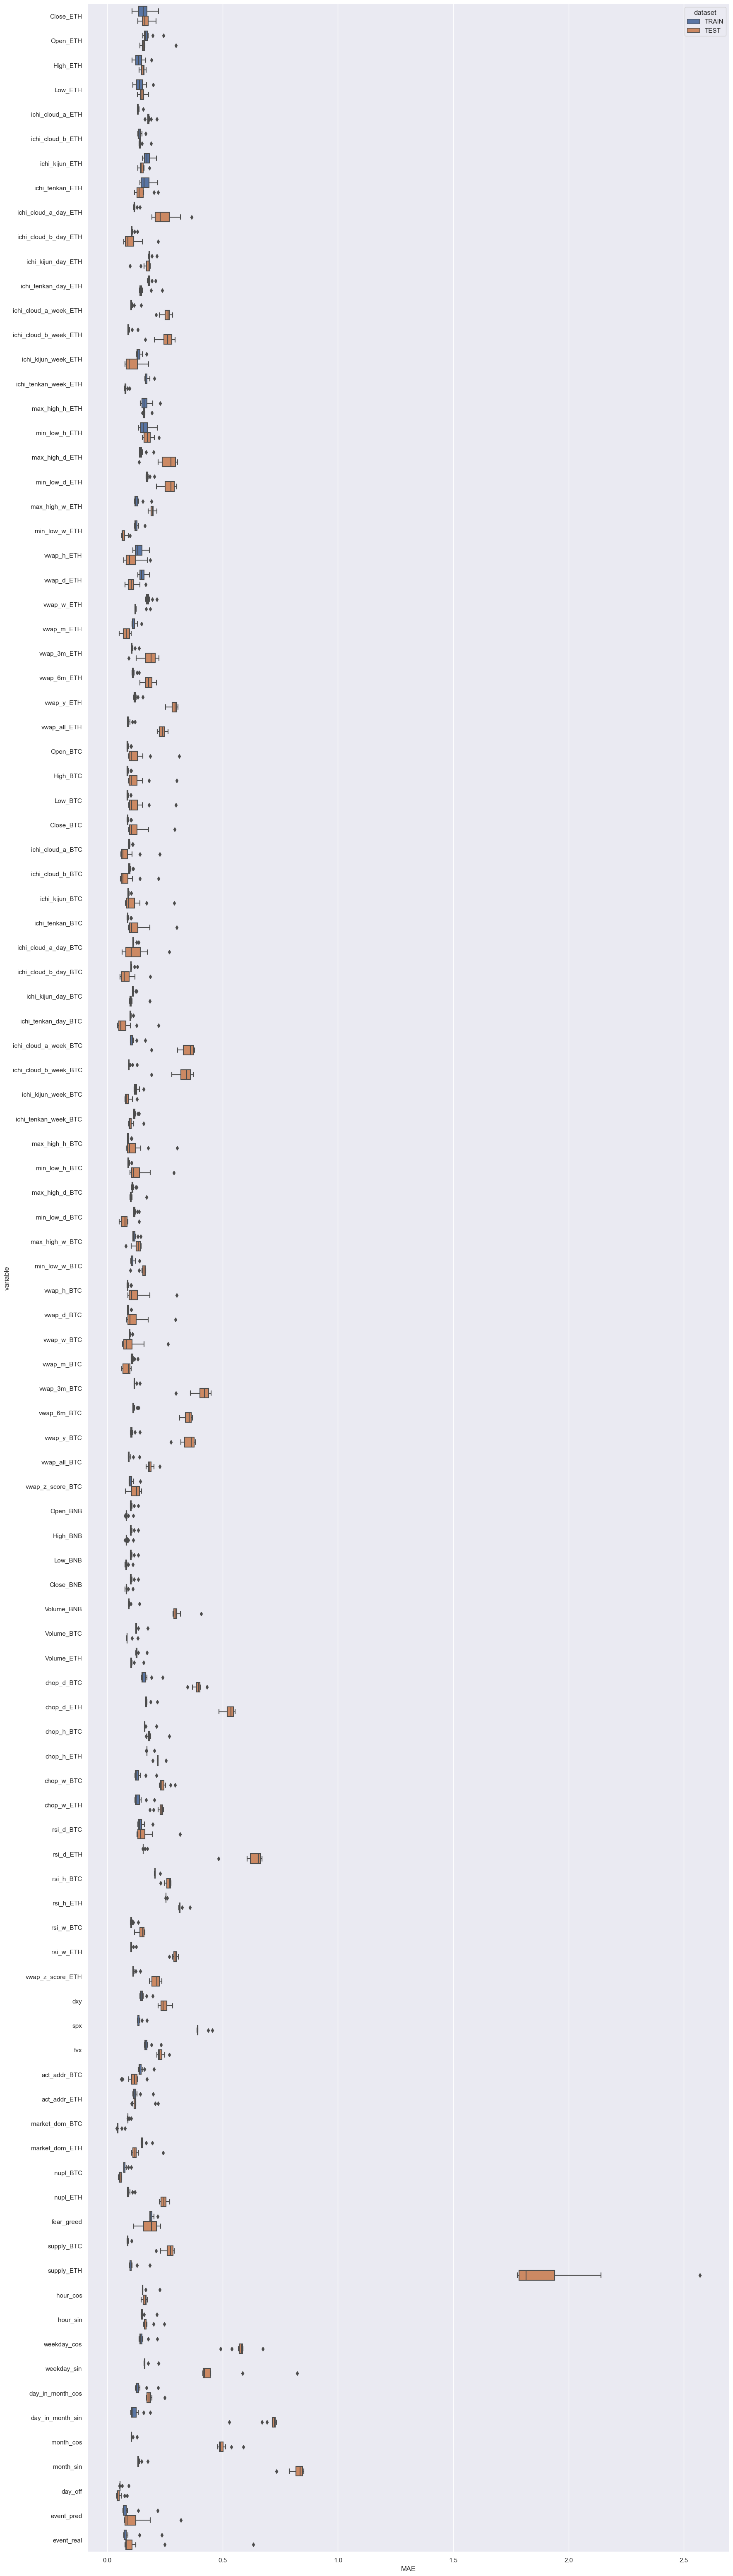

In [115]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

In [116]:
encoder_model.layers[3].get_weights()

[array([[-0.14908111, -0.25852454,  0.21072698, ..., -0.00853999,
         -0.4849035 ,  0.28407204],
        [ 0.7378712 ,  0.4417993 , -0.2571957 , ...,  0.5507797 ,
         -0.29452017,  0.06976644],
        [ 0.08333265, -0.02467195,  0.3551086 , ...,  0.11828244,
         -0.38065758, -0.3723053 ],
        ...,
        [ 0.14060685,  0.3700976 ,  0.03074688, ...,  0.15552463,
         -0.06403676,  0.4914607 ],
        [-0.3666275 , -0.16463551,  0.40934098, ...,  0.15917179,
          0.15132178,  0.19668087],
        [-0.28717053, -0.22378759, -0.19973123, ...,  0.01991064,
          0.11227136,  0.02510585]], dtype=float32),
 array([ 0.00211958, -0.08706866, -0.21484193,  0.03199458, -0.29140013,
         0.03142498, -0.06178816, -0.14945963, -0.00360236,  0.07989246,
        -0.0510178 ,  0.25625187, -0.13548248,  0.04409462, -0.17041525,
        -0.01945651,  0.03032514,  0.12723164,  0.16260786,  0.03530738,
        -0.16084756, -0.08466777,  0.06714974,  0.28522515, -0.149

## Prediction Models

### LSTM all features

In [117]:
X_train_sca.shape

(60932, 12, 104)

In [118]:
X_train_sca.shape[-1]

104

In [119]:
X_train_sca.shape[-2:]

(12, 104)

In [120]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [121]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [122]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1905/1905 [==============================] - 9s 5ms/step


(60932, 12, 32)

In [123]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

10/21 [=============>................] - ETA: 0s

21/21 [==============================] - 0s 6ms/step


(644, 12, 32)

In [124]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [125]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [126]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [127]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((60932, 12, 36), (644, 12, 36))

#### Correlations

In [128]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



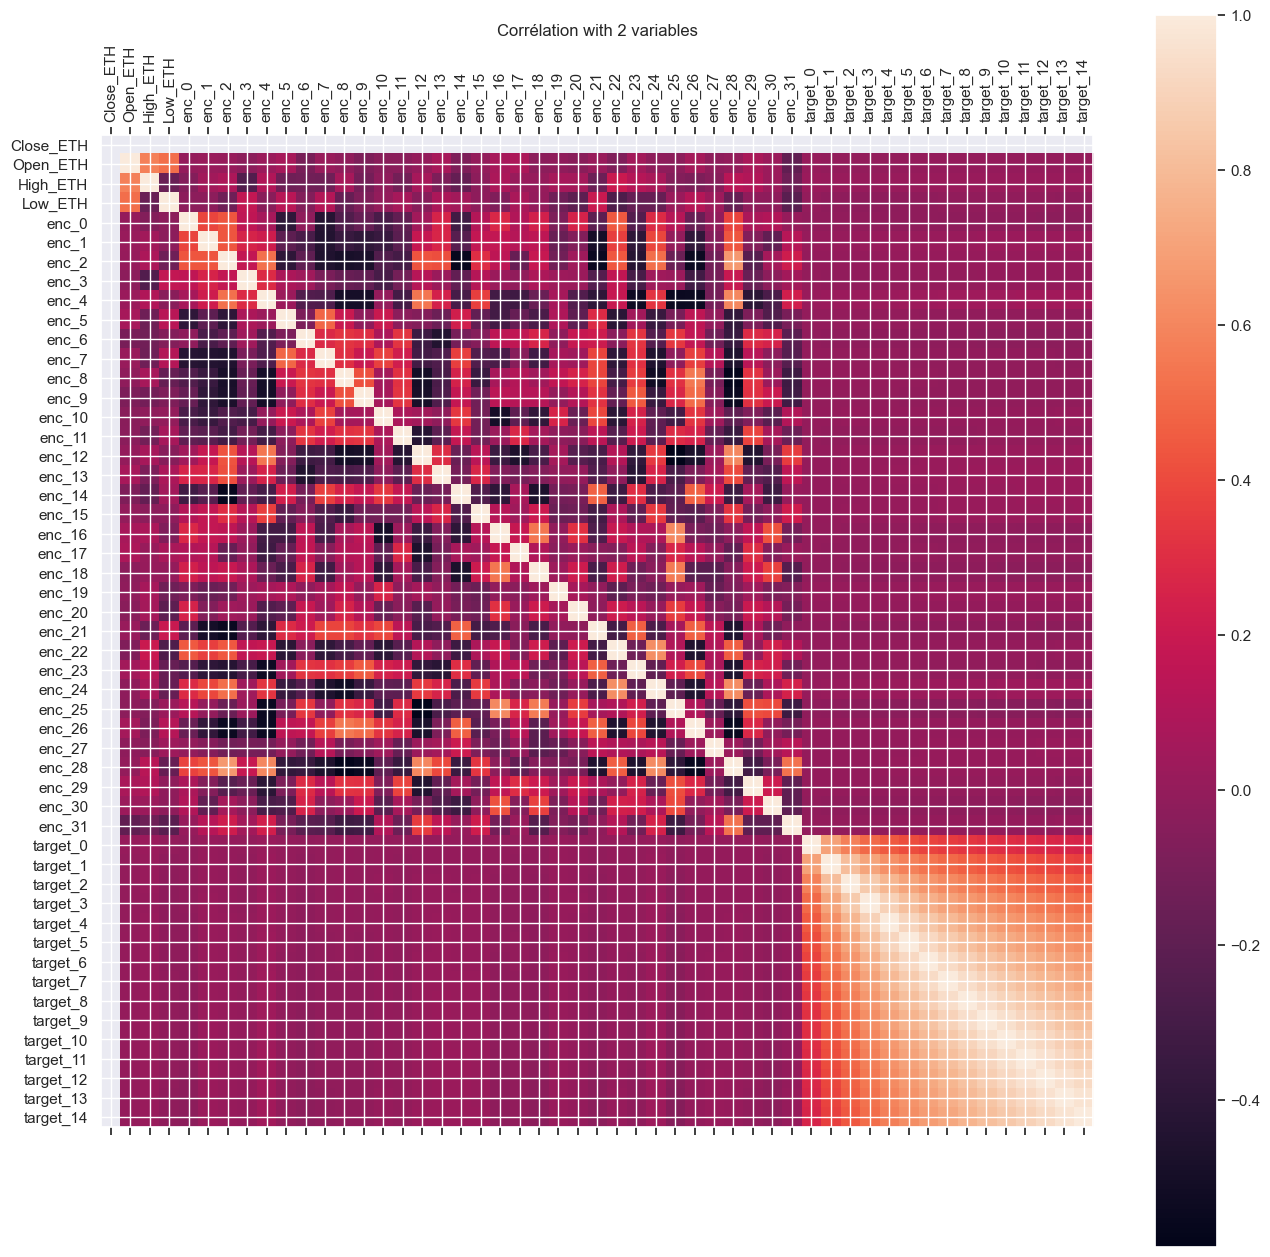

In [129]:
fig = plot_corr(corr_matrix_min)

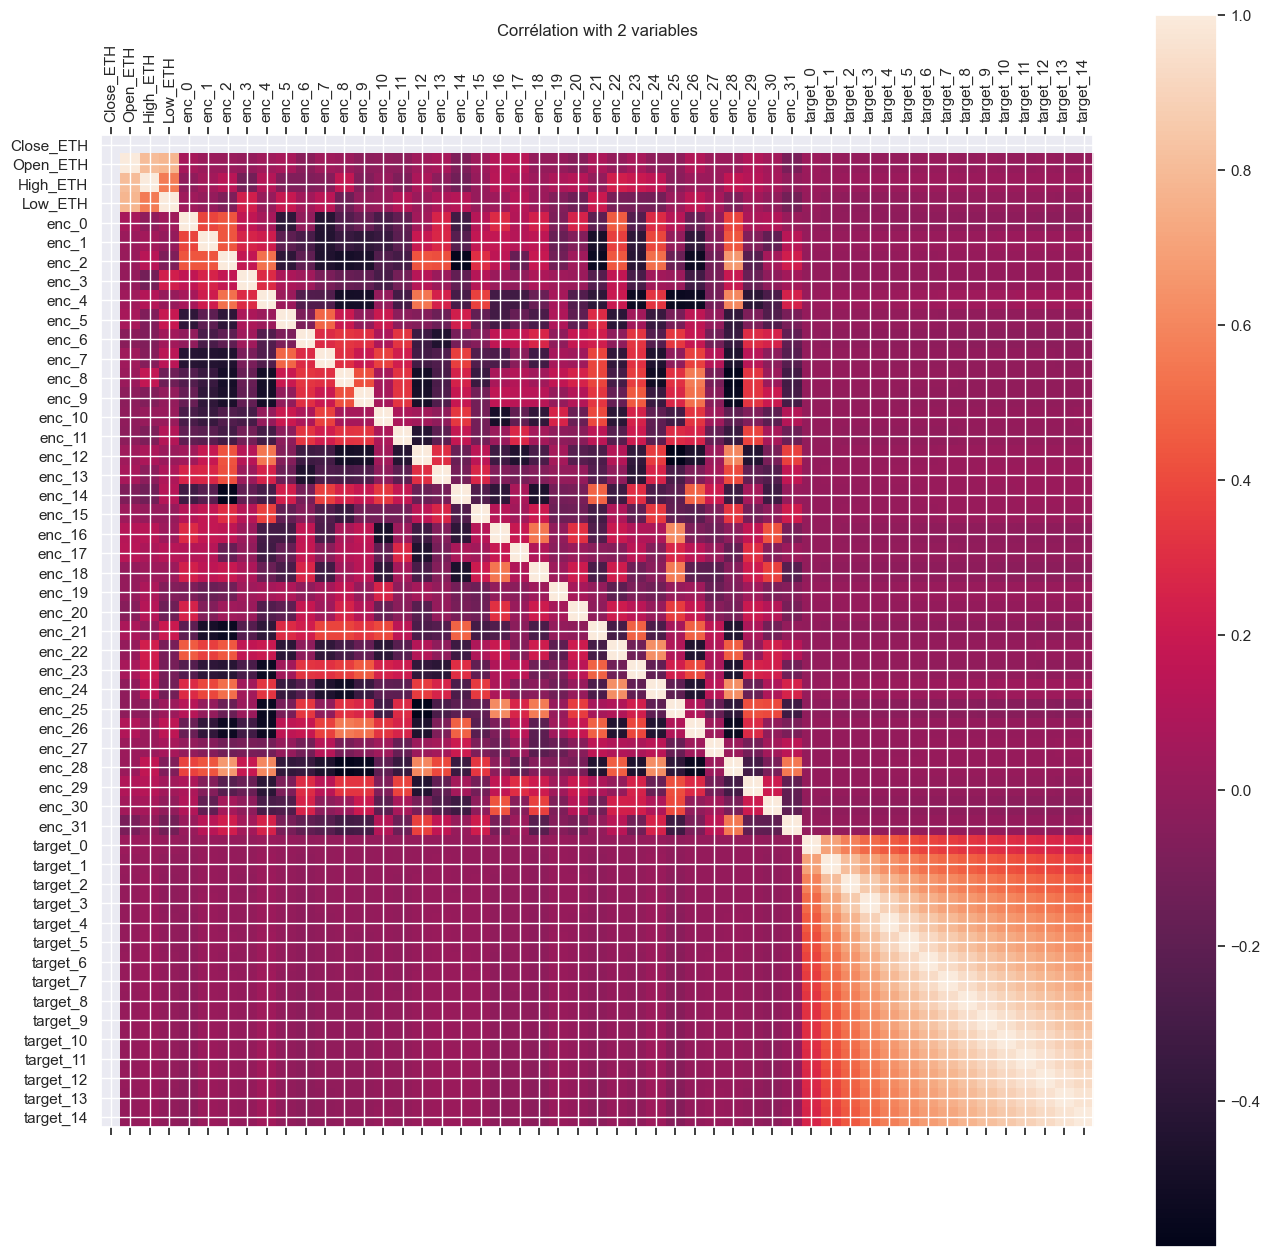

In [130]:
fig = plot_corr(corr_matrix_max) 

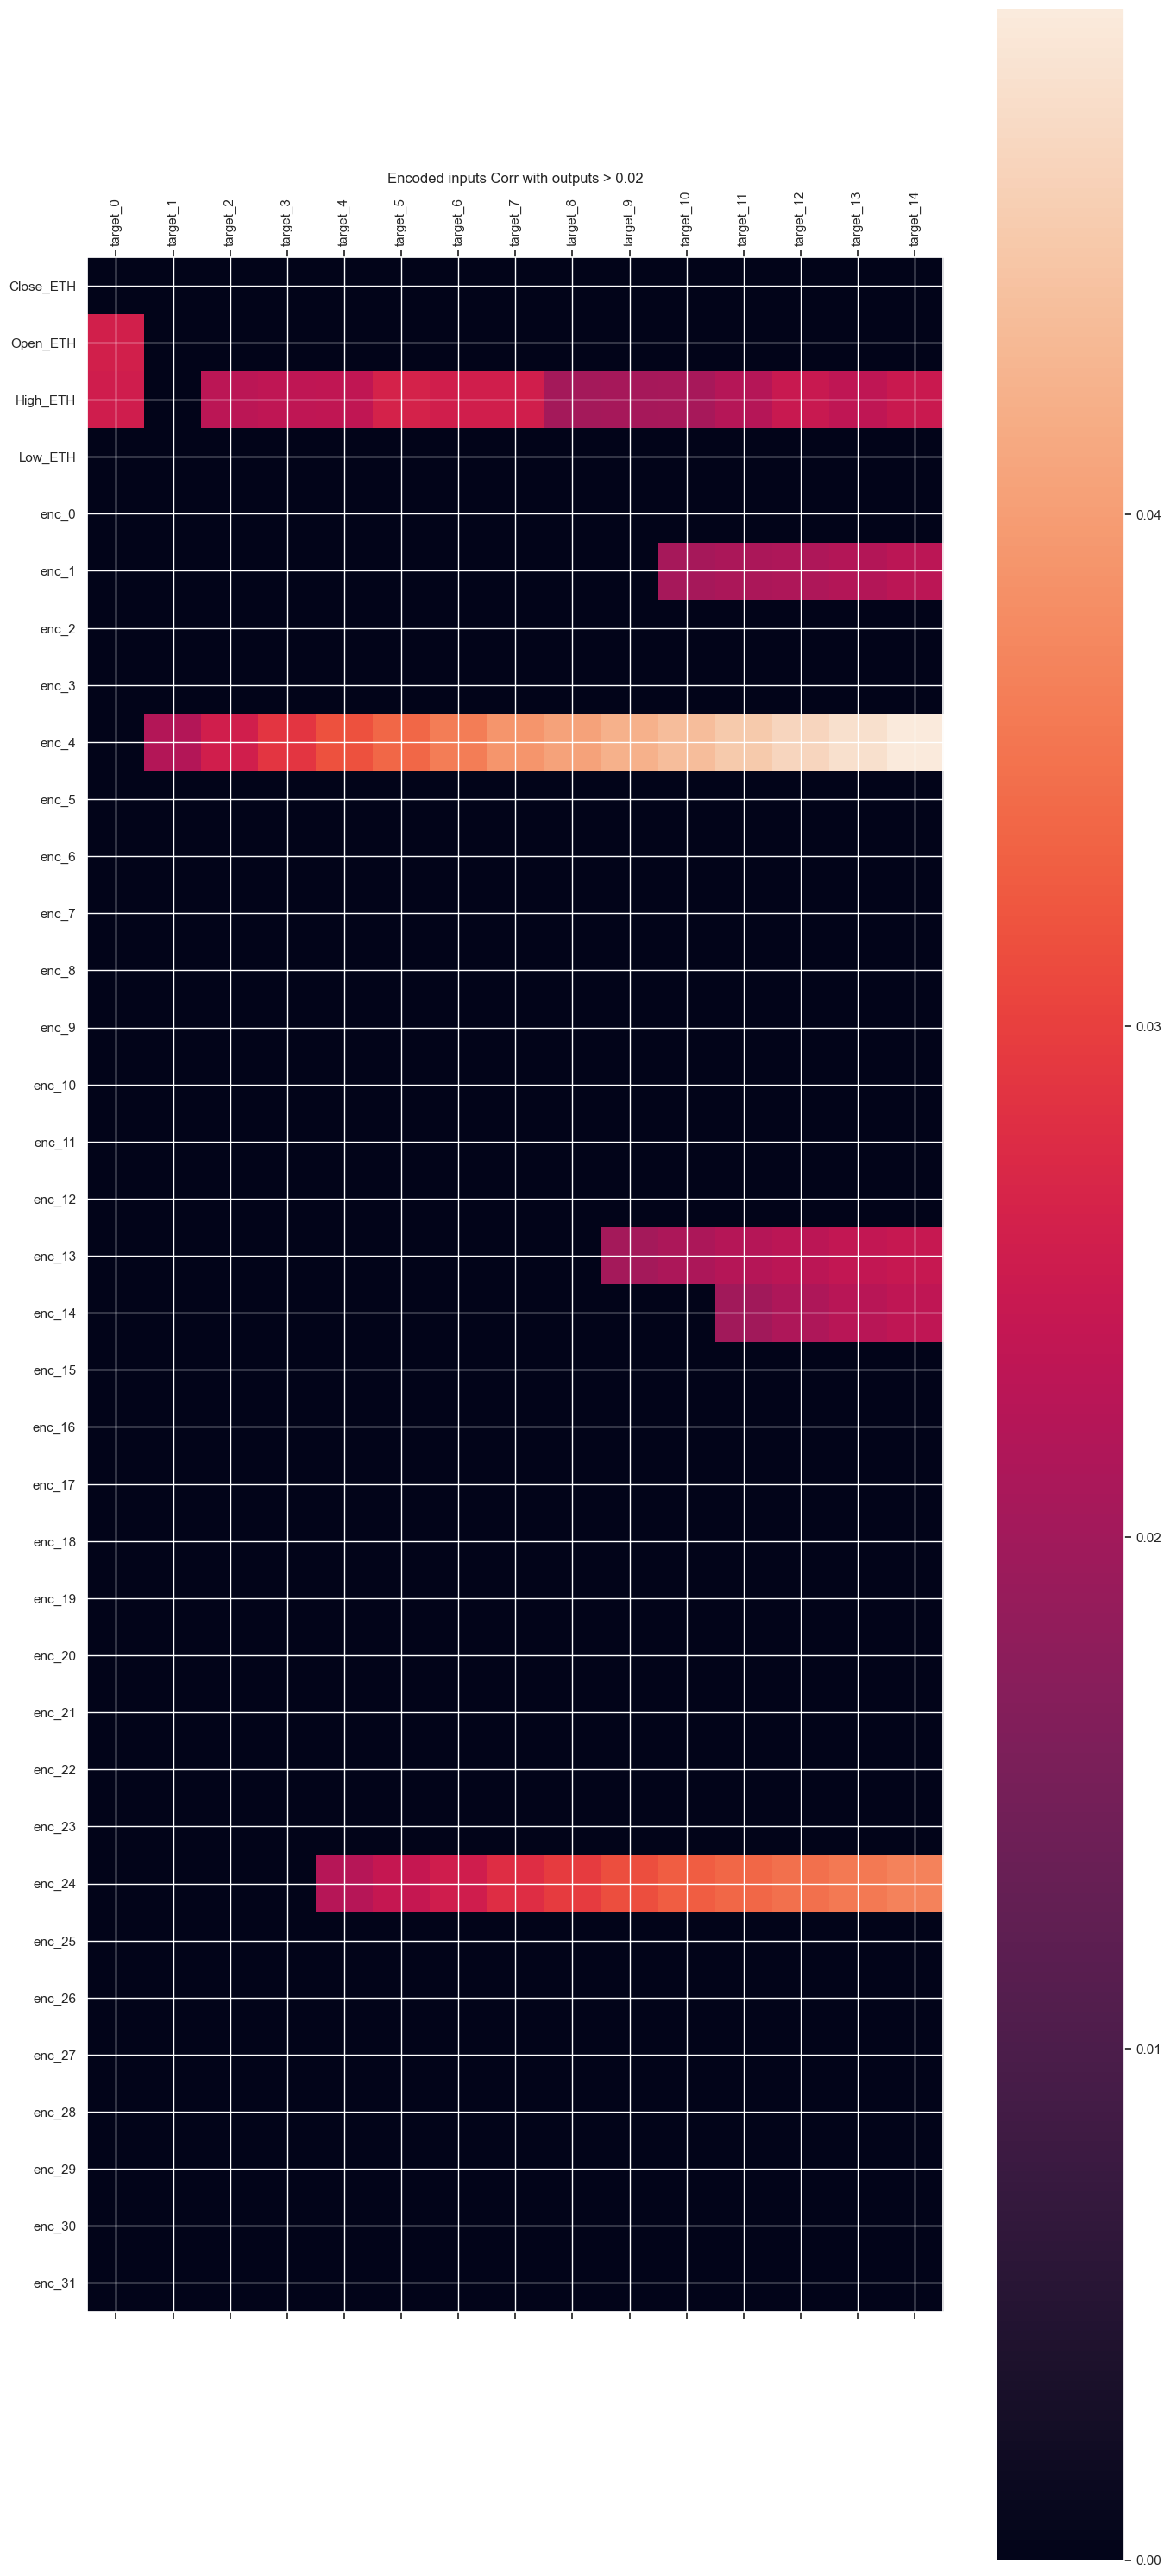

In [131]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

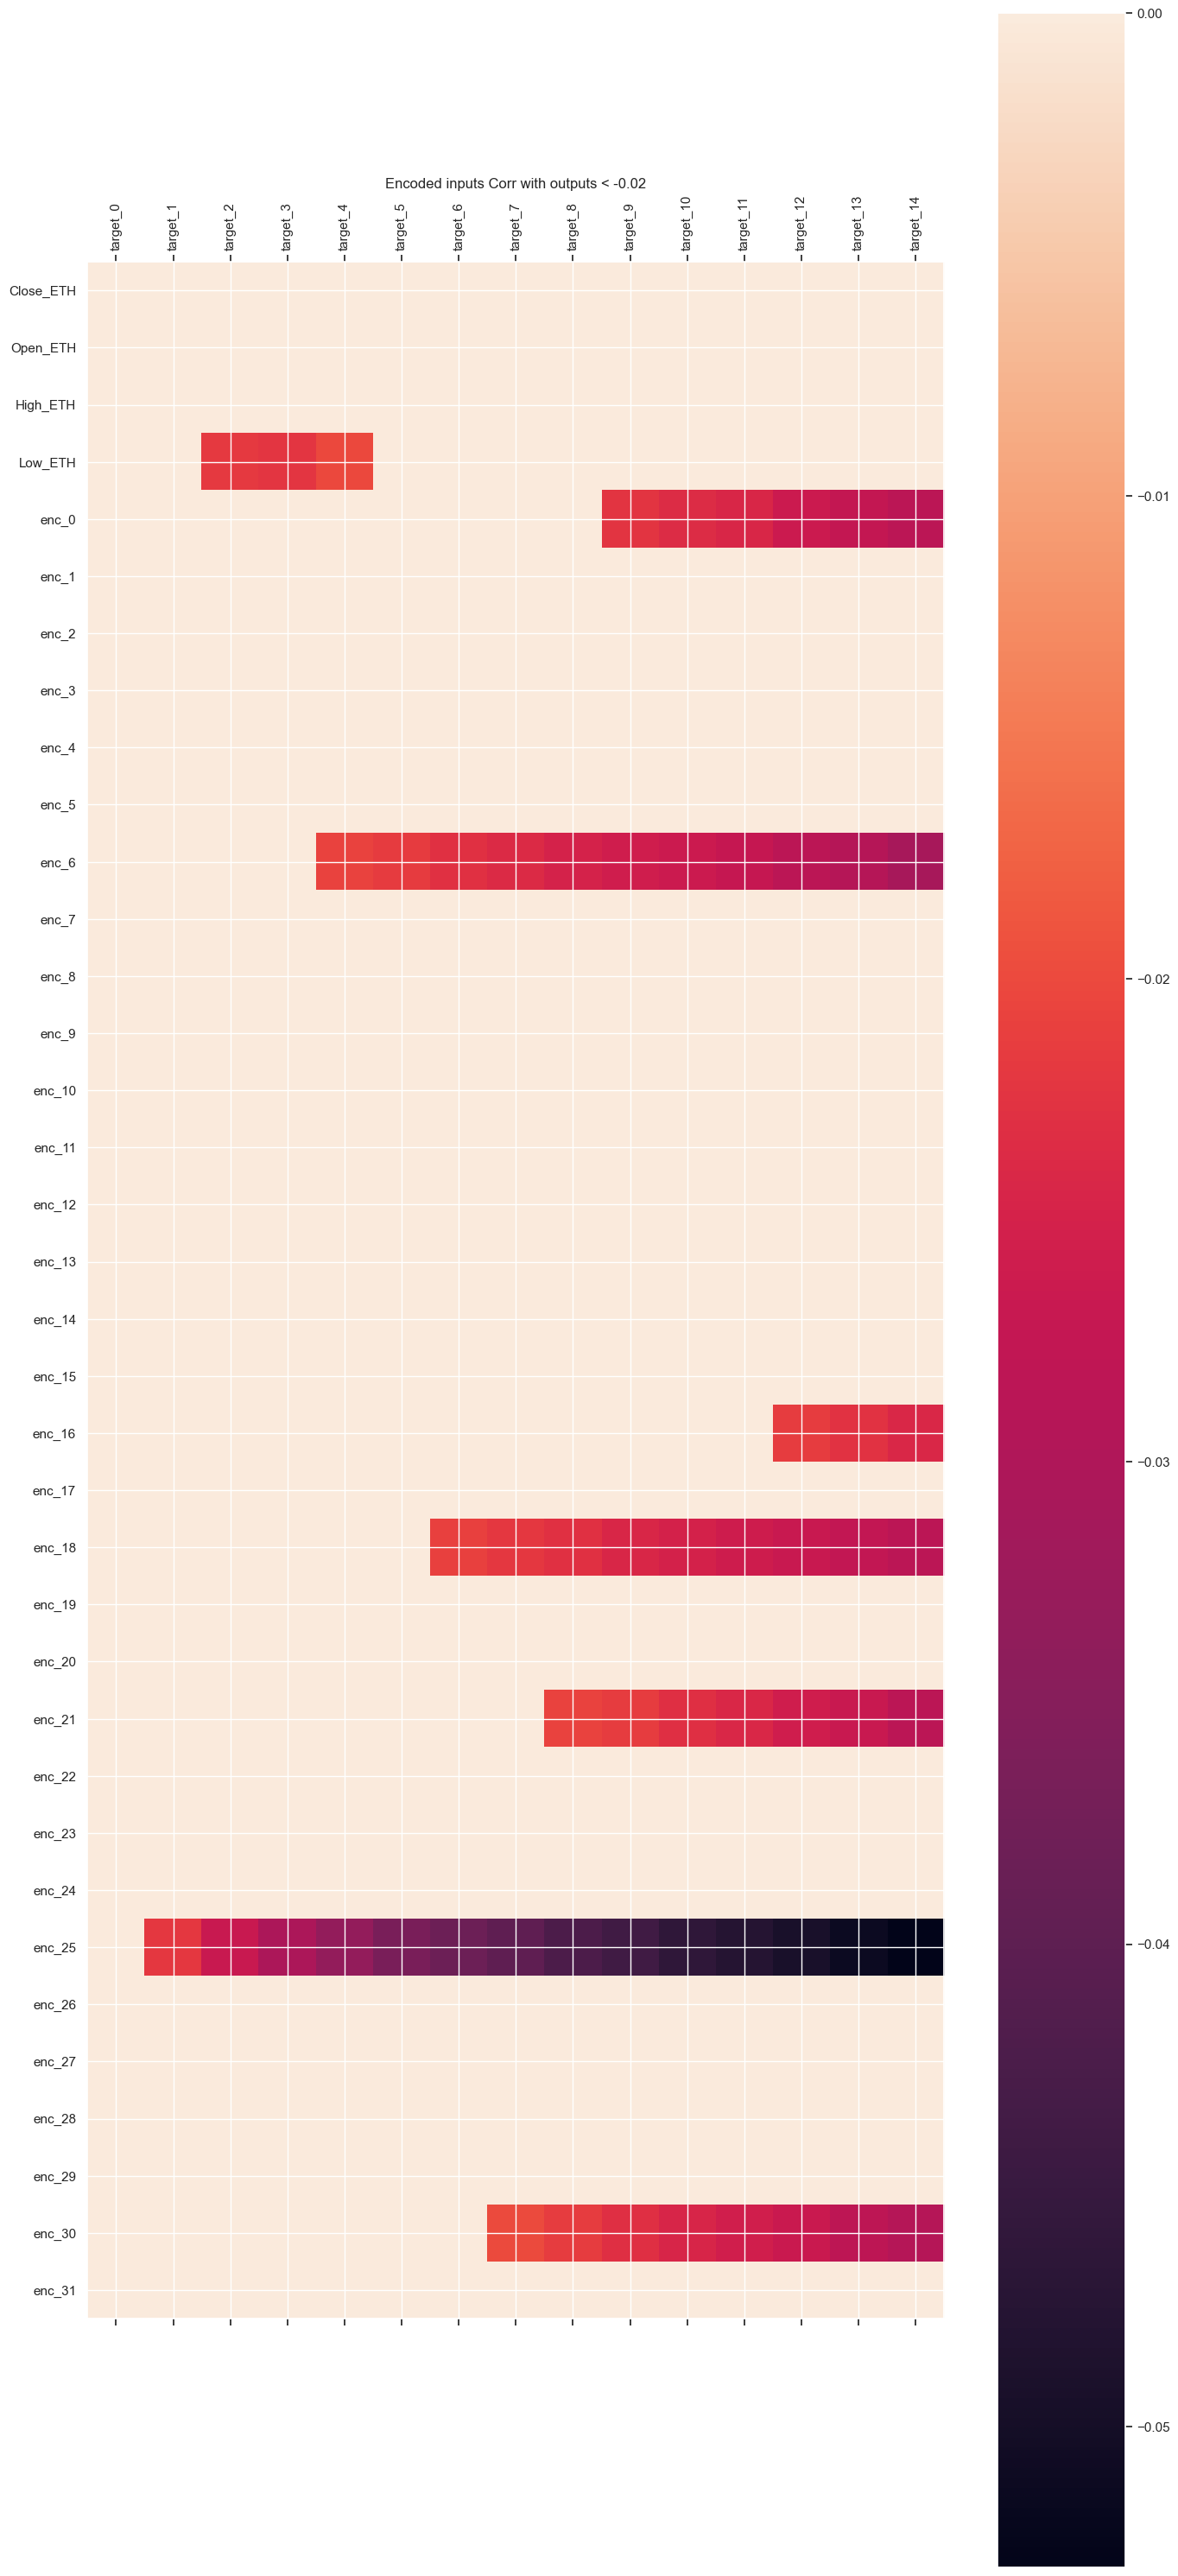

In [132]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [133]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [134]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [135]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [136]:
MODE_AUTO_SELECT

2

In [137]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 4, 6, 13, 14, 16, 18, 21, 24, 25, 30]
nb encoded features:  12


In [138]:
X_train_.shape

(60932, 12, 36)

In [139]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  8, 10, 17, 18, 20, 22, 25, 28, 29, 34])

In [140]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [141]:
X_train_.shape

(60932, 12, 16)

#### Train

Epoch 1/15


1905/1905 [==============================] - 21s 11ms/step - loss: 1.0345 - val_loss: 0.4320
Epoch 2/15
1905/1905 [==============================] - 20s 10ms/step - loss: 0.9958 - val_loss: 0.4329
Epoch 3/15
1905/1905 [==============================] - 19s 10ms/step - loss: 0.9733 - val_loss: 0.4401
Epoch 4/15
1905/1905 [==============================] - 19s 10ms/step - loss: 0.9341 - val_loss: 0.4296
Epoch 5/15
1905/1905 [==============================] - 19s 10ms/step - loss: 0.8863 - val_loss: 0.4333
Epoch 6/15
1905/1905 [==============================] - 20s 11ms/step - loss: 0.8479 - val_loss: 0.4261
Epoch 7/15
1905/1905 [==============================] - 20s 10ms/step - loss: 0.7912 - val_loss: 0.4357
Epoch 8/15
1905/1905 [==============================] - 19s 10ms/step - loss: 0.7432 - val_loss: 0.4562
Epoch 9/15
1905/1905 [==============================] - 19s 10ms/step - loss: 0.7026 - val_loss: 0.4459
Epoch 10/15
1905/1905 [==============================] - 19s 10ms/step - lo

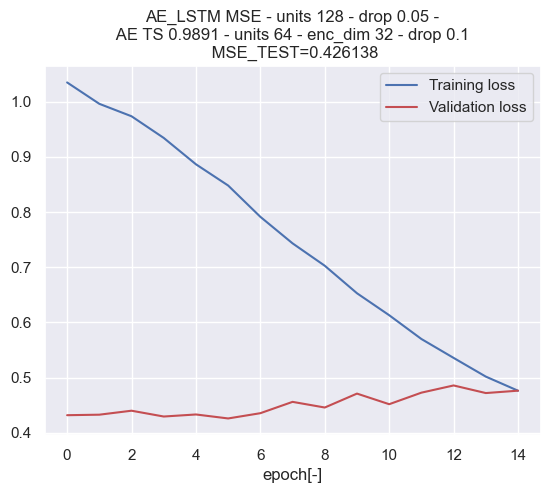

Save model:  data/mdl_predict_autoenc_lstm


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


In [142]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 15#30
patience = 0#10
dropout_rate = 0.05#0.1
n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1

if MODE_TRAIN_PREDICTOR:

    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    #optim = tf.optimizers.Adam()
    optim = tf.keras.optimizers.legacy.Adam()
    if patience is not None:
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                        verbose=1, patience=patience,
                                        restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(
        tf.keras.layers.LSTM(
            n_units,
            return_sequences=False,
            input_shape=X_train_.shape[-2:],
            #kernel_regularizer=reg,
            #bias_regularizer=reg,
        )
    )
    multi_step_model.add(tf.keras.layers.LayerNormalization())
    multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
    #multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1,
        )
    else:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1, 
            callbacks=[es],
        )
    # eval
    mse_curr = np.min(multi_step_history.history['val_loss'])
    print("MSE TEST : ", mse_curr)

    # plot MSE
    name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
    plot_train_history(
        multi_step_history,
        f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
        saveFolder="data",
    )


if MODE_TRAIN_PREDICTOR:
    print("Save model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model.save(path_mdl_predict_autoenc_lstm)
else:
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    print(multi_step_model.summary())

#### Results

Save mdl

In [143]:
X_train_.shape

(60932, 12, 16)

Predict

In [144]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

21/21 [==============================] - 0s 4ms/step


Plots

In [145]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(60945,)
(60945,)


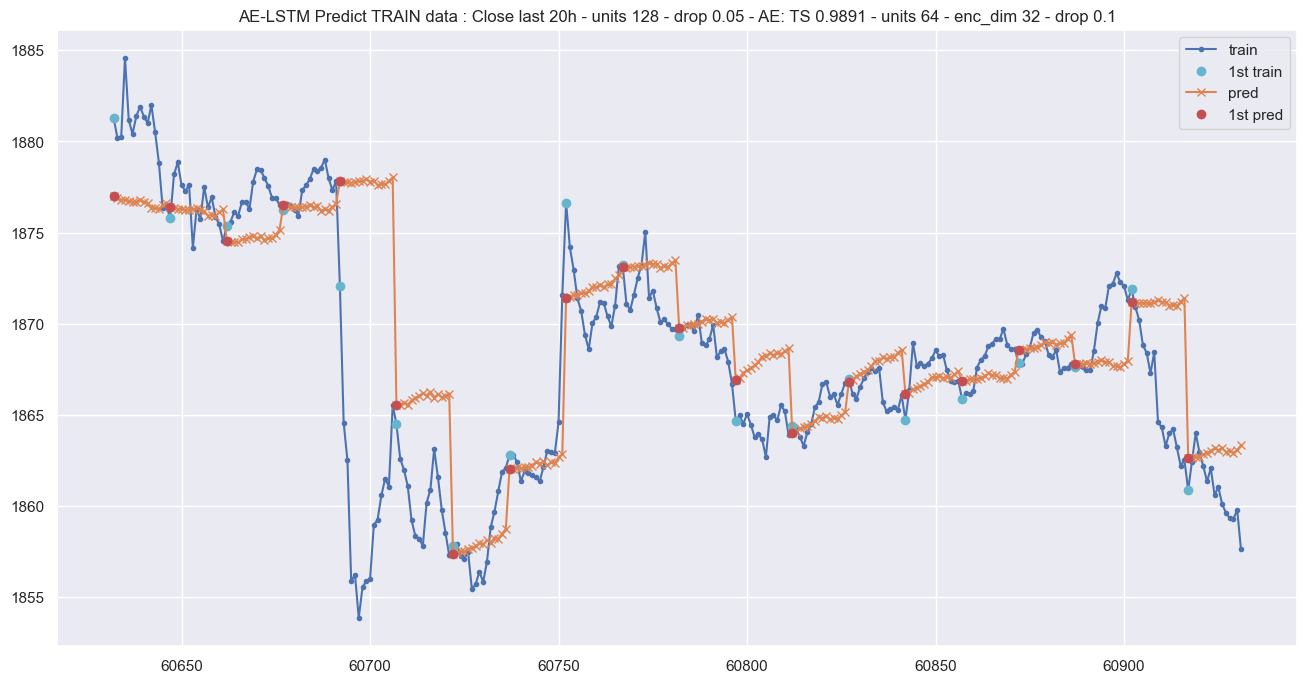

In [146]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

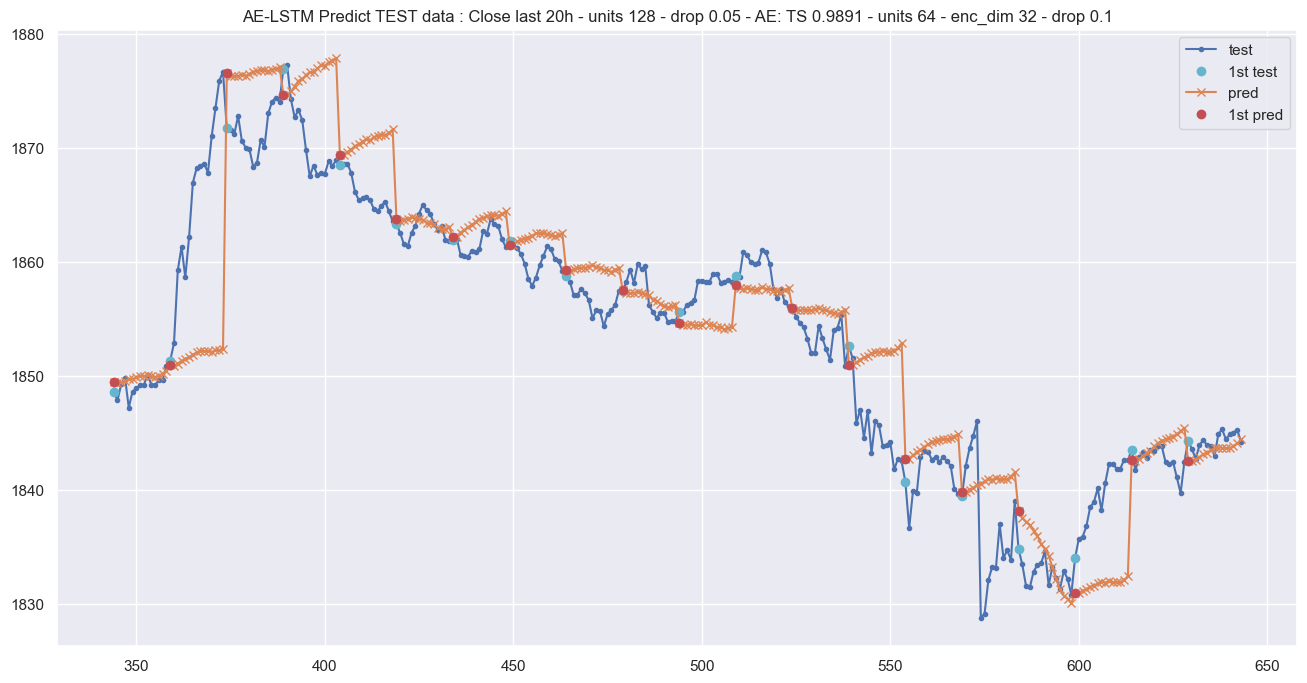

In [147]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

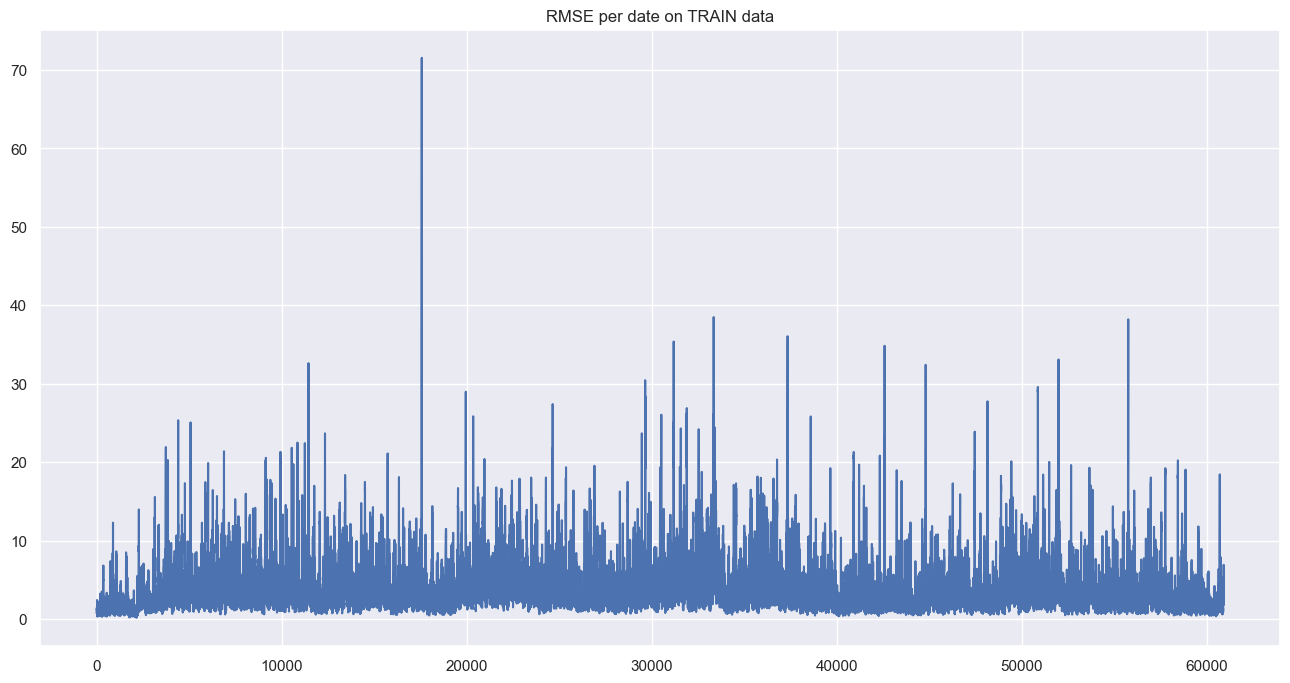

In [148]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

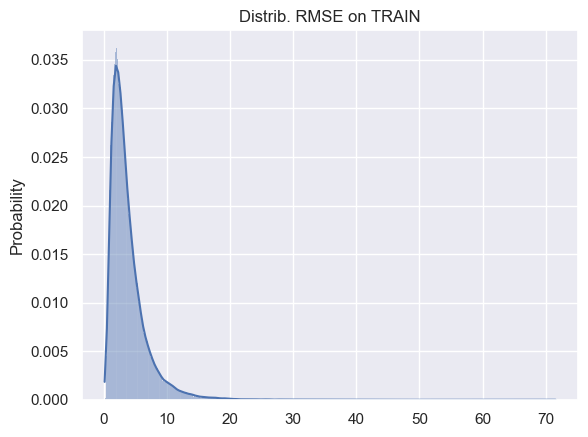

In [149]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 3.85')

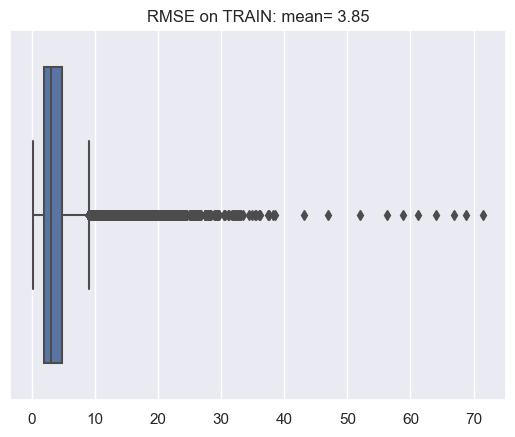

In [150]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

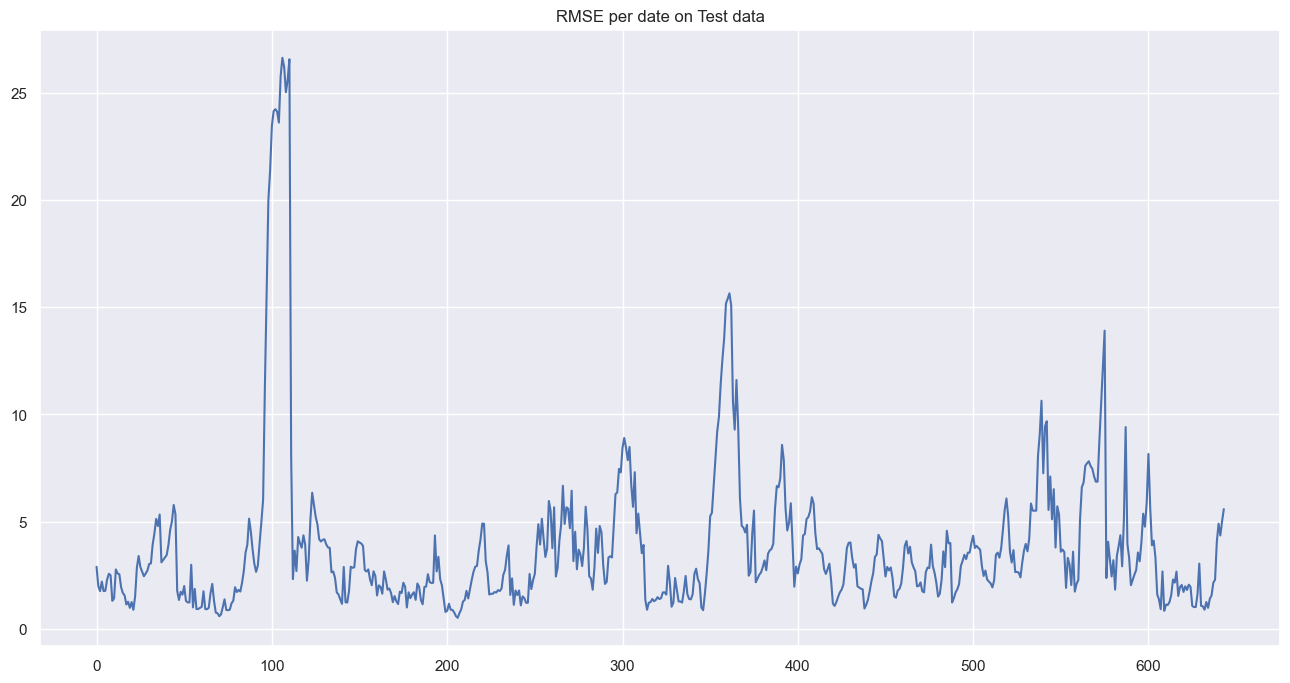

In [151]:
arr_mse = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="mse")

<AxesSubplot: ylabel='Probability'>

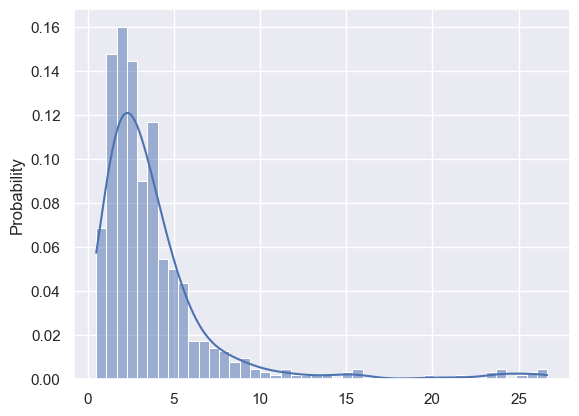

In [152]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.82')

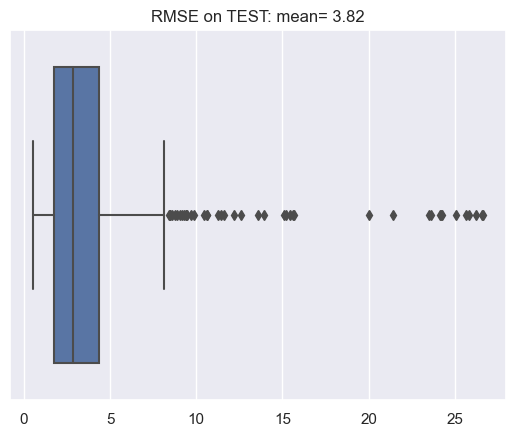

In [153]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [154]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1844.83 1844.99 1845.25 1844.21 1844.17 1842.94 1843.07 1842.6  1841.69
 1841.01 1840.64 1840.14 1838.83 1840.64 1839.49]
[1844.55851936 1844.50706931 1844.61414697 1844.88458953 1845.21263855
 1845.30894249 1845.59719468 1845.76913458 1845.78628459 1845.93469819
 1846.03473995 1846.12554709 1846.39423067 1846.73811047 1847.18752884]


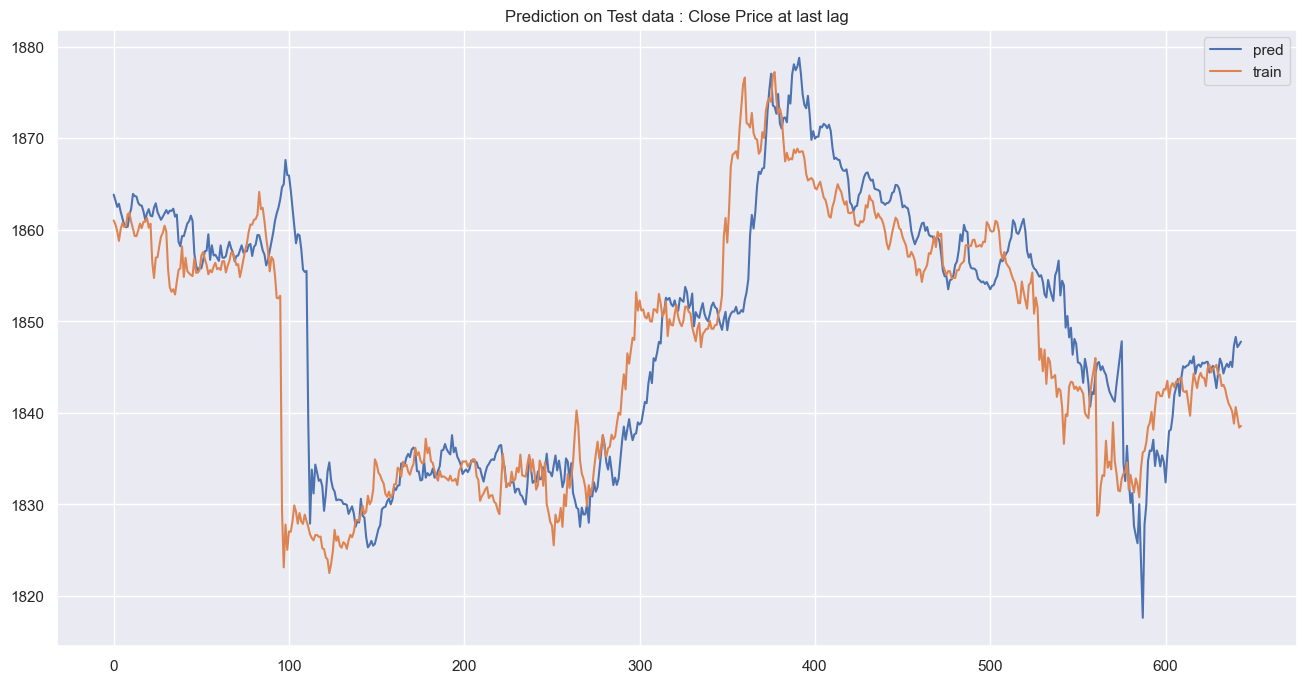

In [155]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

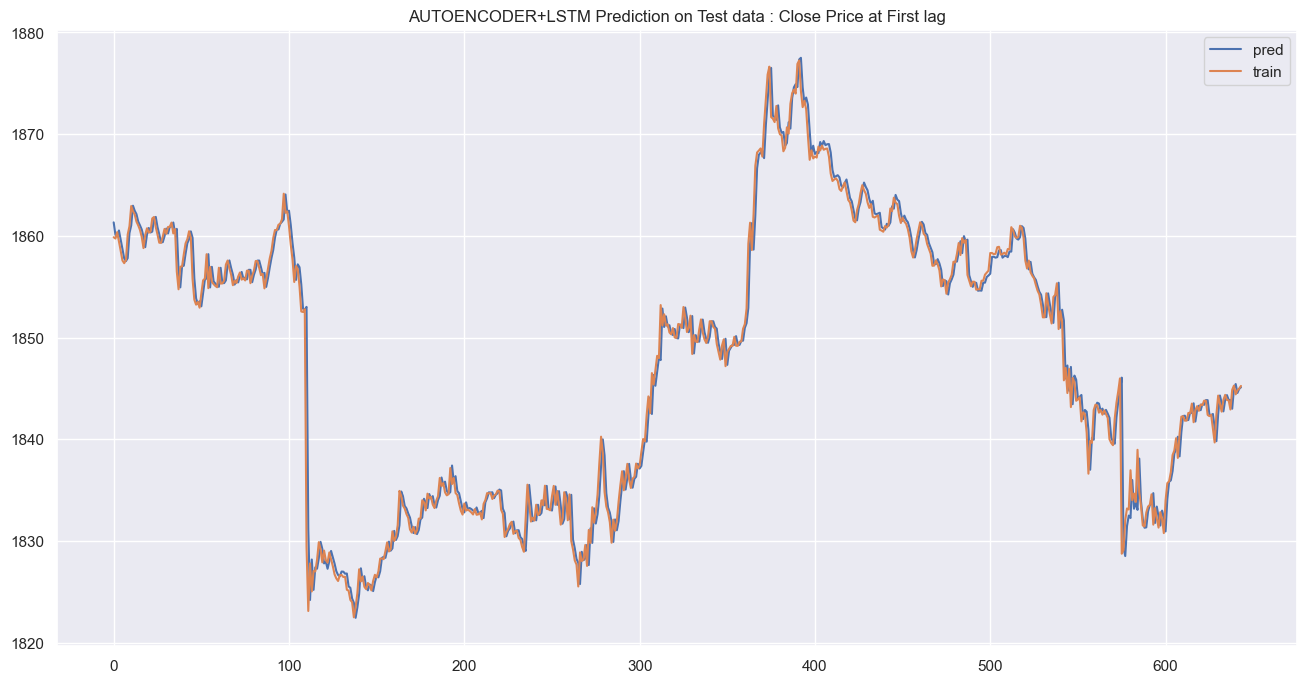

In [156]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

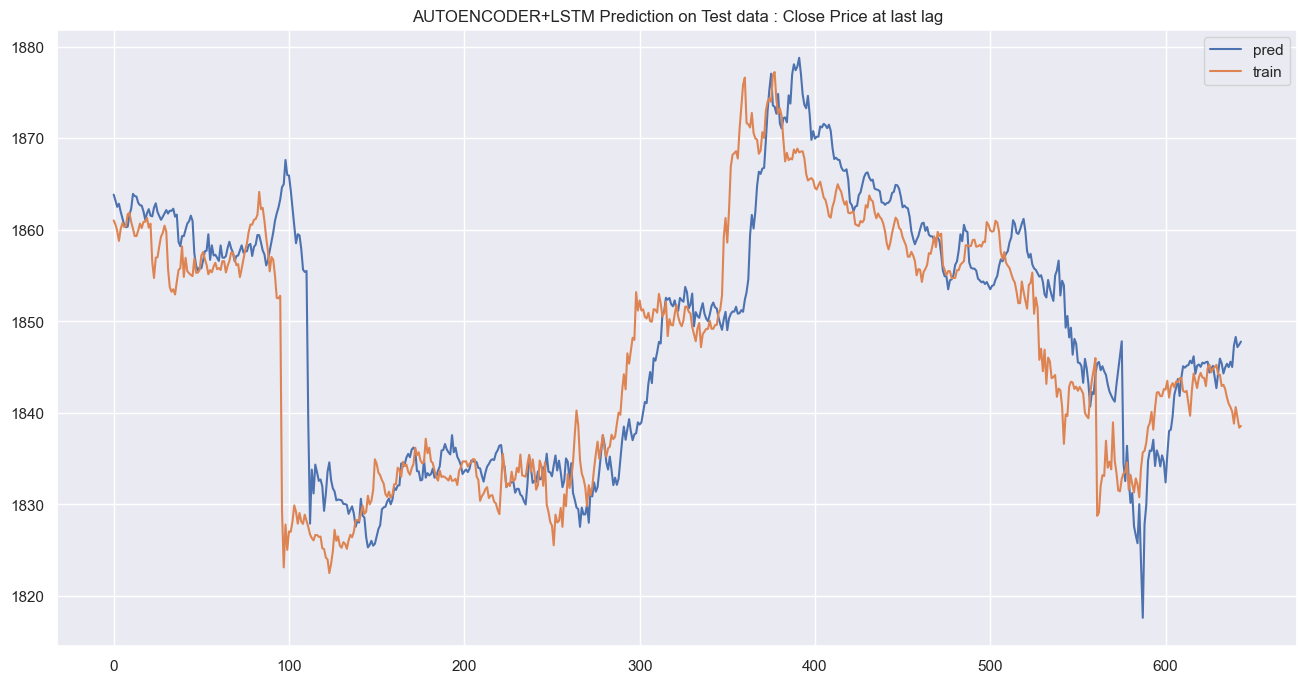

In [157]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [158]:
X_test_sca.shape

(644, 12, 104)

In [159]:
df_feat["Close_ETH"].iloc[-1]

1838.59

In [160]:
df_feat["Close_ETH"].iloc[-1]

1838.59

In [161]:
len(list_i_enc_select)

12

In [162]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1843.07 1842.6  1841.69 1841.01 1840.64 1840.14 1838.83 1840.64 1839.49
 1838.39 1838.58 1838.59]
X_last[0,:,0] after divide by price:
[1.00243665 1.00218102 1.00168607 1.00131623 1.00111498 1.00084304
 1.00013053 1.00111498 1.00048951 0.99989122 0.99999456 1.        ]
(1, 12, 104)
X_last_sca[0,:,0]:
[ 0.70724843  0.63407658  0.49240342  0.38653776  0.32893439  0.25109199
  0.04714491  0.32893439  0.14989687 -0.0213564   0.00822371  0.00978056]
(1, 12, 104)
1/1 [==============================] - 0s 181ms/step
X_last_encoded[0,:,0]:
[ 0.00478977  0.08432287 -0.01174123  0.0010737  -0.03639797 -0.06729349
 -0.08238114 -0.08731841 -0.07718371 -0.06472106 -0.04577072 -0.05207792]
(1, 12, 32)
X_last_encoded_sca[0,:,0]:
[-0.09441314  0.21673042 -0.15908451 -0.10895089 -0.2555448  -0.37641197
 -0.43543682 -0.45475203 -0.4151038  -0.3663483  -0.2922122  -0.31688675]
(1, 12, 32)
X_last_sca[0,0,0:4]:
[0.70724843 0.63242118 0.48947244 0.79191404]
X_last_enc

In [163]:
X_last_encoded_sca.shape

(1, 12, 32)

In [164]:
list_i_enc_select

[0, 1, 4, 6, 13, 14, 16, 18, 21, 24, 25, 30]

In [165]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 12, 12)

In [166]:
X_last_sca[:,:,0:4].shape

(1, 12, 4)

In [167]:
X_train_.shape

(60932, 12, 16)

In [168]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
61625  1691018700000   1838.84   1840.65  1838.83    1840.64    565.5509   
61626  1691019000000   1840.65   1840.65  1839.49    1839.49    186.1157   
61627  1691019300000   1839.50   1839.50  1837.83    1838.39    451.4727   
61628  1691019600000   1838.40   1838.59  1837.60    1838.58    307.7195   
61629  1691019900000   1838.59   1838.59  1838.58    1838.59      6.8825   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1748.127508        1747.54819   
1      2023-01-01 00:05:00       1748.127508        1747.54819   
2      2023-01-01 00:10:00       1748.127508        1747.54819   
3      2023-01-01 00:15:00       1748.127508        1747.54819   
4      2023-01-01 00:20:00       1748.127508        1747.54819   
...                    ...               ...               ...   
61625  2023-08-02 23:25:00       1840.925000        1835.14000   
61626  2023-08-02 23:30:00       1841.152500        1837.12000   
61627  2023-08-02 23:35:00       1841.527500        1837.22000   
61628  2023-08-02 23:40:00       1841.527500        1837.22000   
61629  2023-08-02 23:45:00       1841.567500        1837.22000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
61625        1842.120  ...         NaN            NaN           NaN   
61626        1842.120  ...         NaN            NaN           NaN   
61627        1841.705  ...         NaN            NaN           NaN   
61628        1841.590  ...         NaN            NaN           NaN   
61629        1841.590  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
61625               NaN         0.0               NaN         0.0      0.0   
61626               NaN         0.0               NaN         0.0      0.0   
61627               NaN         0.0               NaN         0.0      0.0   
61628               NaN         0.0               NaN         0.0      0.0   
61629               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
61625                  NaN  False  
61626                  NaN  False  
61627                  NaN  False  
61628                  NaN  False  
61629                  NaN  False  

[61630 rows x 136 columns]

In [169]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [170]:
y_last_pred_unscaled

array([[1.000077 , 1.0000926, 1.0001901, 1.0003285, 1.0004268, 1.000474 ,
        1.0005878, 1.0006785, 1.0006567, 1.000631 , 1.0005887, 1.0005571,
        1.0005971, 1.0007321, 1.0009278]], dtype=float32)

In [171]:
df_feat["Close_ETH"].iloc[-1]

1838.59

In [172]:
y_last_pred_raw

array([[1838.7316, 1838.7603, 1838.9396, 1839.194 , 1839.3746, 1839.4614,
        1839.6708, 1839.8375, 1839.7974, 1839.7501, 1839.6722, 1839.6141,
        1839.6879, 1839.9359, 1840.2958]], dtype=float32)

In [173]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [174]:
list_pred

[1839.194,
 1839.3746,
 1839.4614,
 1839.6708,
 1839.8375,
 1839.7974,
 1839.7501,
 1839.6722,
 1839.6141,
 1839.6879,
 1839.9359,
 1840.2958]

In [175]:
save_list(list_pred, path_save_pred_vals)

In [176]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [177]:
list_pred_reload

[1839.194,
 1839.3746,
 1839.4614,
 1839.6708,
 1839.8375,
 1839.7974,
 1839.7501,
 1839.6722,
 1839.6141,
 1839.6879,
 1839.9359,
 1840.2958]